# Crystallinity maps of semicrystalline polymer (R-BAPB) 
## 2D X-ray scattering experiment



In [2]:
import h5py
import numpy as np
import scipy as scipy
from scipy import optimize
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
import time
import peakutils

%matplotlib inline

In [3]:
#Initial global parameters

file_name = "H://LP/R-BAPB/print72.h5"
file_num = '72'
data_inner_directory = "data/data" # path to data inside the file
map_width = 1 #default value
min_ROI_q = 570 # region of interest for q, data point indices
max_ROI_q = 650
min_ROI_chi = 0 # region of interest for angle chi, data point indices
max_ROI_chi = 720 

In [4]:
#Opening h5 file
file = h5py.File(file_name, "r") # reading mode
all_scans = file[data_inner_directory] 
map_width = int(all_scans.shape[0]**0.5) 
q_set = file["data/q"] # actual values for q and chi


chi_set = file["data/chi"]

In [6]:
all_scans.shape

(14641, 720, 2000)

In [5]:
q_set = file["data/q"]
q_set = np.asarray(q_set)

In [6]:
q_set = 360*np.arcsin(q_set*0.8349/(4*np.pi))/np.pi

In [17]:
file.close()

In [6]:
dset = file['data']

In [10]:
list(dset.keys())

['chi', 'data', 'program', 'pyFAI', 'q', 'start_time', 'title']

<HDF5 dataset "program": shape (), type "|S5">

In [5]:
np.save('q_set',q_set)
np.save('chi_set', chi_set)
np.save('test_scan', all_scans[600])

In [63]:
q_set[230]

0.5040773

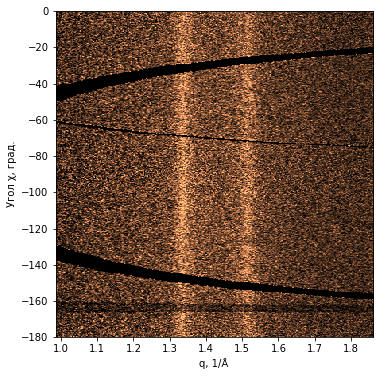

In [44]:
scan = all_scans[14640]
fig, ax = plt.subplots(figsize=(6,6))
plt.ylabel("Угол \u03C7, град.")
plt.xlabel("q, 1/\u212B")
ax.imshow(scan[:360,450:850], cmap='copper', interpolation='none', extent=[q_set[450],q_set[850],chi_set[0],chi_set[360]], clim = (0,1.5), aspect = 0.005)
#plt.savefig('azim-amo.pdf')11

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.hist(scan[1], bins = 300)
plt.show()

In [37]:
scan = np.load('scan_sum1434.npy')

In [ ]:
for row in scan:
    row[row<0]= np.nan
    
print (scan[10])

In [55]:
360/np.pi*np.arcsin(0.08/np.pi)

2.9183655519365588

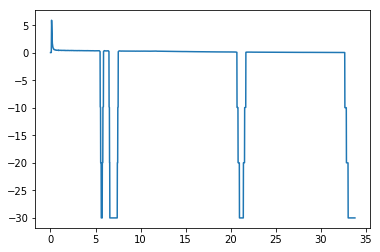

In [40]:
profile = scan[100]+scan[101]+scan[102]
    
plt.plot(q_set,profile)

In [ ]:
#Global normalization
mu = np.nanmean(scan)
sigma = np.nanstd(scan)

mu,sigma

In [ ]:
for row in scan:
    for cell in row:
        if cell:
            cell = (cell-mu)/sigma

In [ ]:
plt.imshow(scan, cmap = 'jet', clim = (0.01,0.7))

array([ -320.,  -320.,  -140., ..., -7180., -7180., -7180.], dtype=float32)

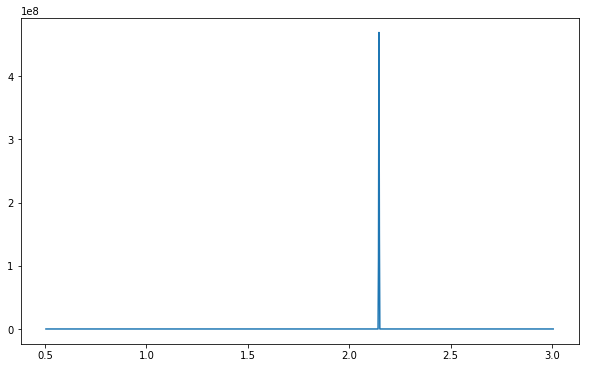

In [26]:

min_ROI_q = 230 # region of interest for q, data point indices
max_ROI_q = 1375

profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
        
j_counter = 0
for j in range (min_ROI_chi,max_ROI_chi):
    profile = np.nan_to_num(scan[j])           
    profile_sum += profile
    j_counter+=1
#profile_sum/=j_counter


x = q_set[min_ROI_q:max_ROI_q]
y = profile_sum[min_ROI_q:max_ROI_q]

plt.figure(figsize=(10,6))
plt.plot(x,y)
profile_sum

In [ ]:
#local normalisation
local_mu = np.nanmean(profile_sum[min_ROI_q-100:max_ROI_q+100])
local_sigma = np.nanstd(profile_sum[min_ROI_q-100:max_ROI_q+100])

local_profile = profile_sum[min_ROI_q-100:max_ROI_q+100]

for cell in local_profile:
    cell = (cell - local_mu)/local_sigma

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(q_set[min_ROI_q:max_ROI_q],local_profile[100:-100])


In [ ]:
local_profile[100:-100] == profile_sum[min_ROI_q:max_ROI_q]

596

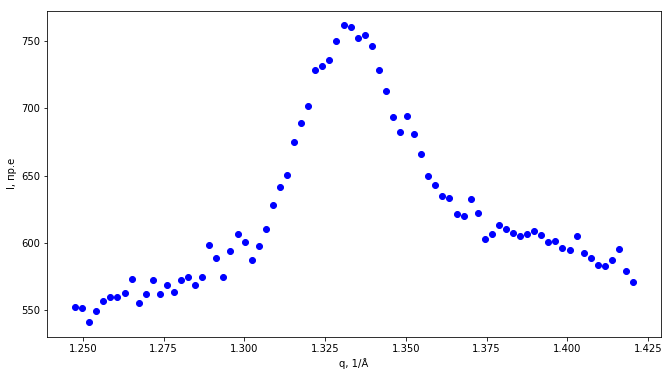

In [16]:
### without normalization
new_scan = all_scans[1000]
#for i in range(100):
 #   new_scan+=all_scans[i]


min_ROI_q =  570 # region of interest for q, data point indices
max_ROI_q = 650

new_profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
        
j_counter = 0
for j in range (min_ROI_chi,max_ROI_chi):
    if j not in range(330,360): #exclude beamstop
        profile = new_scan[j]    
        if (-10 not  in profile[min_ROI_q:max_ROI_q]):
            new_profile_sum += profile
            j_counter+=1
#new_profile_sum/=j_counter


x = q_set[min_ROI_q:max_ROI_q]
y = new_profile_sum[min_ROI_q:max_ROI_q]

plt.figure(figsize=(11,6))
plt.ylabel("I, пр.е")
plt.xlabel("q, 1/\u212B")
plt.plot(x,y, 'bo')

j_counter
#plt.savefig("waxs_profile.pdf")

In [18]:
new_profile_sum-=550

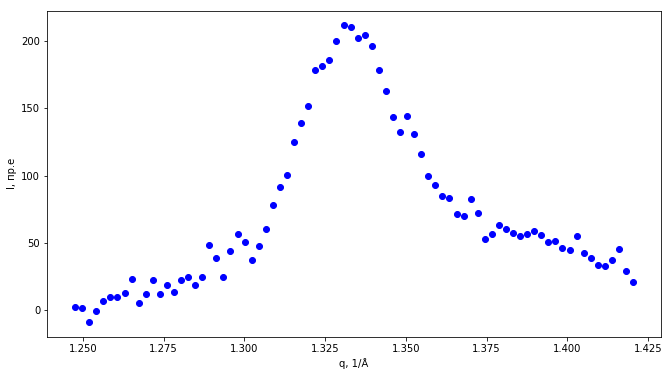

In [19]:
x = q_set[min_ROI_q:max_ROI_q]
y = new_profile_sum[min_ROI_q:max_ROI_q]

plt.figure(figsize=(11,6))
plt.ylabel("I, пр.е")
plt.xlabel("q, 1/\u212B")
plt.plot(x,y, 'bo')

In [20]:
np.save('profile_gauss1', new_profile_sum[min_ROI_q:max_ROI_q])
np.save('q_gauss1', q_set[min_ROI_q:max_ROI_q])

In [33]:
np.save('profile', new_profile_sum[min_ROI_q:max_ROI_q])

In [ ]:
#Mapping by simply integrating in ROI_q


#baseline = np.load('1434profile.npy')
start_time = time.time() #time counter
stn_map_data = np.zeros((map_width,map_width), dtype=np.float32) 

for i in range(map_width**2):
        current_scan = all_scans[i]   
        profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
        
        j_counter = 0
        for j in range (min_ROI_chi,max_ROI_chi):
            profile = current_scan[j]           
            if (-10 not in profile[min_ROI_q-70:max_ROI_q+70]):
                profile_sum += profile
                j_counter+=1
        profile_sum/=j_counter
        
        
        y_wide = scipy.signal.savgol_filter(profile_sum[min_ROI_q-70:max_ROI_q+70], window_length= 25, polyorder= 3, deriv=0, delta=0.1, axis=-1, mode='interp', cval=0.0)
        #base = peakutils.baseline(profile_sum[min_ROI_q-70:max_ROI_q+70], deg=5)
        #y_wide= profile_sum[min_ROI_q-70:max_ROI_q+70]-base
        

        x_set = q_set[min_ROI_q:max_ROI_q]
        y_set = y_wide[70:-70]

        #popt, pcov = scipy.optimize.curve_fit(gaussian, x, y, p0=[1.3,0.05,0.5,0.1], method = 'dogbox')
        I = scipy.integrate.trapz(x = x_set, y = y_set)
        print(I)
        
        
        x = int(i%map_width)
        y = int(i//map_width)
        
        stn_map_data[y, x]=I
        print(i,"--- %s seconds ---" % (time.time() - start_time))

#saving map data

np.save(file_num + 'trapz_map_data', stn_map_data)

In [ ]:
#Summing all  scans of the experiment


scan_sum = np.zeros((all_scans.shape[1],all_scans.shape[2]), dtype = np.float32)
start_time = time.time()
for scan in all_scans:
    scan_sum+=scan
    print("--- %s seconds ---" % (time.time() - start_time))
    
scan_sum/=all_scans.shape[0] #normalizing

#saving

np.save('scan_sum' + file_num, scan_sum)

In [ ]:
#Assembling a normilized profile from different parts of a scan (because yeah I don't have mask files)

#scan_sum = np.load('scan_sum' + file_num + '.npy', )

#TODO - зашкал при i=6 - почему???
#Сшивка между срезами - чем больше N, тем меньше разница

M = all_scans.shape[2] #number of points in profile
N=3 #number of slices
halo_profile = np.zeros(M, dtype=np.float32)
for i in range(N):  
    
    min_slice = int(M*i/N)
    max_slice = int(M*(i+1)/N)
    counter = 0 
    print(i, min_slice, max_slice)
    local_sum = np.zeros(M, dtype=np.float32)
    
    for j in range(min_ROI_chi, max_ROI_chi):
        profile = scan_sum[j]
        if not any(x<=0 for x in profile[min_slice:max_slice]):
            local_sum[min_slice:max_slice]+=profile[min_slice:max_slice]        
            counter +=1
                
    print(counter)
    halo_profile[min_slice:max_slice] += (local_sum[min_slice:max_slice]/counter) 


fig = plt.figure(figsize=(15,10))
plt.plot(q_set,halo_profile, label = 'halo profile')


#Setting scale 
ax = fig.add_subplot(2, 1, 1)
ax.loglog(q_set,halo_profile, label = 'loglog halo profile')

#ax.set_xscale('log')
#ax.set_yscale('log')
plt.legend()

#saving
np.save('halo_profile' + file_num, scan_sum)
np.savetxt('halo_profile' + file_num + '.txt', halo_profile)
np.savetxt('q_set' + file_num + '.txt', q_set)


In [ ]:
#Loading corrected halo profile
halo_baseline = np.loadtxt('halo_baseline' + file_num +'.txt')
print(halo_baseline)
#Integrating, saving

#1434 halo slice: 45-1998
halo_min = 1
halo_max = 2000

I =scipy.integrate.trapz(y = halo_baseline, x = q_set[halo_min-1:halo_max])
print (I)

halo_pars = [halo_min, halo_max, I]
np.savetxt('halo_params' + file_num + '.txt', halo_pars)


In [ ]:
#Mapping by simply integrating in ROI_q

#baseline = np.load('1434profile.npy')
start_time = time.time() #time counter
simple_map_data = np.zeros((map_width,map_width), dtype=np.float32) 

for i in range(map_width**2):
        current_scan = all_scans[i]   
        profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
        
        j_counter = 0
        for j in range (min_ROI_chi,max_ROI_chi):
            profile = current_scan[j]           
            if (-10 not in profile[min_ROI_q-70:max_ROI_q+70]):
                profile_sum += profile
                j_counter+=1
        profile_sum/=j_counter
        
        base = peakutils.baseline(profile_sum[min_ROI_q-70:max_ROI_q+70], deg=5)
        profile_sum[min_ROI_q-70:max_ROI_q+70]-=base
        I =scipy.integrate.trapz(y = profile_sum[min_ROI_q:max_ROI_q], x = q_set[min_ROI_q:max_ROI_q])
        x = int(i%map_width)
        y = int(i//map_width)
        
        simple_map_data[y, x]=I
        print(i,"--- %s seconds ---" % (time.time() - start_time))

#saving map data

#np.save(file_num + 'simple_map_data', simple_map_data)

In [ ]:
plt.imshow(simple_map_data, cmap = "jet") #jet, magma, inferno, copper
plt.figure(figsize=(15,15))

plt.imsave(file_num +"map_q_{}-{}_chi_{}-{}-savitskiy_jet.png".format(min_ROI_q, max_ROI_q, min_ROI_chi, max_ROI_chi), \
          simple_map_data, cmap = "jet")


In [ ]:
print(simple_map_data)

In [ ]:
#Creating histogram
test_data = simple_map_data.flatten()
plt.hist(test_data, bins = 300)
plt.show()
#saving

In [ ]:
#Thresholding map data after looking at a histogram

masked_simple_map_data = np.zeros((map_width,map_width), dtype=np.float32) 
for i in range(map_width**2):
    x = int(i%map_width)
    y = int(i//map_width)
    if simple_map_data[x,y]>22:
        masked_simple_map_data[x,y] = simple_map_data[x,y] 
        
plt.imshow(masked_simple_map_data, cmap = "jet")
plt.figure(figsize=(15,15))

In [ ]:
#Creating mask

mask = np.load('1434mask_data.npy')
plt.imshow(mask, cmap = "jet") #jet, magma, inferno, copper
plt.figure(figsize=(15,15))
#mask = masked_simple_map_data > 0
#saving map data and mask

#plt.imsave(file_num +"map_q_{}-{}_chi_{}-{}-masked_jet.png".format(min_ROI_q, max_ROI_q, min_ROI_chi,\
 #                                                                  max_ROI_chi), masked_simple_map_data, cmap = "jet")
#np.save(file_num + "masked_map_data", masked_simple_map_data)
#np.save(file_num + "mask_data", mask)

In [ ]:
#Getting a normalized masked  profile of ROI_q
scan_count = 0
masked_scan_sum = np.zeros((all_scans.shape[1],all_scans.shape[2]), dtype = np.float32)
start_time = time.time()
for i in range(map_width**2):
    x = int(i%map_width)
    y = int(i//map_width)
    if not mask[y,x]:
        masked_scan_sum+=all_scans[i]
        scan_count +=1
        
    print(i,"--- %s seconds ---" % (time.time() - start_time))
    
masked_scan_sum/=scan_count #normalizing

#saving
np.save(file_num + 'negative_masked_scan_sum', masked_scan_sum)

In [ ]:
plt.imshow(map_data, cmap = "magma")
plt.figure(figsize=(15,15))

In [ ]:
file.close()

In [5]:
import h5py
import numpy as np
f = h5py.File("mytestfile.hdf5", "w")
dset = f.create_dataset("data", (14641, 2000), dtype= np.float32)

In [23]:
start_time = time.time() #time counter
counts = np.load('counts72.npy')
mask = np.load('mask72.npy')
for i in range(all_scans.shape[0]):
    profile = np.zeros(all_scans.shape[2], dtype=np.float32)
    current_scan = all_scans[i]*mask
    for chi in range(all_scans.shape[1]):
         if chi not in range(300,330):
                profile+=current_scan[chi]
    profile/=counts
    dset[i]=profile
    
    print(i,"--- %s seconds ---" % (time.time() - start_time))

        

H:\PROG\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


0 --- 0.20719599723815918 seconds ---
1 --- 0.30113673210144043 seconds ---
2 --- 0.5110888481140137 seconds ---
3 --- 0.7782855033874512 seconds ---
4 --- 0.9310715198516846 seconds ---
5 --- 1.2042555809020996 seconds ---
6 --- 1.3492591381072998 seconds ---
7 --- 1.5675137042999268 seconds ---
8 --- 1.764718770980835 seconds ---
9 --- 1.9692153930664062 seconds ---
10 --- 3.0299670696258545 seconds ---
11 --- 3.207080125808716 seconds ---
12 --- 3.4540464878082275 seconds ---
13 --- 3.5975000858306885 seconds ---
14 --- 3.871283769607544 seconds ---
15 --- 4.025456666946411 seconds ---
16 --- 4.2882044315338135 seconds ---
17 --- 4.464390993118286 seconds ---
18 --- 4.6682281494140625 seconds ---
19 --- 4.892652750015259 seconds ---
20 --- 5.05059289932251 seconds ---
21 --- 5.267797470092773 seconds ---
22 --- 5.457112789154053 seconds ---
23 --- 5.622326374053955 seconds ---
24 --- 5.886779308319092 seconds ---
25 --- 6.030192613601685 seconds ---
26 --- 6.225025653839111 seconds 

217 --- 48.8424859046936 seconds ---
218 --- 48.975377798080444 seconds ---
219 --- 49.164271116256714 seconds ---
220 --- 49.3247709274292 seconds ---
221 --- 49.47715163230896 seconds ---
222 --- 49.67108178138733 seconds ---
223 --- 49.838616609573364 seconds ---
224 --- 50.002095460891724 seconds ---
225 --- 50.28025722503662 seconds ---
226 --- 50.41488027572632 seconds ---
227 --- 50.6343252658844 seconds ---
228 --- 50.821258544921875 seconds ---
229 --- 50.96973752975464 seconds ---
230 --- 51.184638023376465 seconds ---
231 --- 51.40803074836731 seconds ---
232 --- 51.59681701660156 seconds ---
233 --- 51.783371925354004 seconds ---
234 --- 52.12910318374634 seconds ---
235 --- 52.285056352615356 seconds ---
236 --- 52.52623200416565 seconds ---
237 --- 52.68426465988159 seconds ---
238 --- 52.90453267097473 seconds ---
239 --- 53.088082790374756 seconds ---
240 --- 53.31723093986511 seconds ---
241 --- 53.464394330978394 seconds ---
242 --- 53.68427395820618 seconds ---
243 -

435 --- 92.22285628318787 seconds ---
436 --- 92.39600777626038 seconds ---
437 --- 92.66795754432678 seconds ---
438 --- 92.84794640541077 seconds ---
439 --- 93.02583646774292 seconds ---
440 --- 93.32252812385559 seconds ---
441 --- 93.50848841667175 seconds ---
442 --- 93.70140218734741 seconds ---
443 --- 93.89435982704163 seconds ---
444 --- 94.04509377479553 seconds ---
445 --- 94.2488923072815 seconds ---
446 --- 94.38710498809814 seconds ---
447 --- 94.62699437141418 seconds ---
448 --- 94.77590370178223 seconds ---
449 --- 94.9927225112915 seconds ---
450 --- 95.16397738456726 seconds ---
451 --- 95.39340853691101 seconds ---
452 --- 95.53900480270386 seconds ---
453 --- 95.73439764976501 seconds ---
454 --- 95.89855980873108 seconds ---
455 --- 96.0924596786499 seconds ---
456 --- 96.33965635299683 seconds ---
457 --- 96.47969484329224 seconds ---
458 --- 96.72061800956726 seconds ---
459 --- 96.89668226242065 seconds ---
460 --- 97.07341837882996 seconds ---
461 --- 97.2884

649 --- 143.10748505592346 seconds ---
650 --- 143.304443359375 seconds ---
651 --- 143.51498889923096 seconds ---
652 --- 143.74406170845032 seconds ---
653 --- 143.9918143749237 seconds ---
654 --- 144.16470050811768 seconds ---
655 --- 144.35164713859558 seconds ---
656 --- 144.57158827781677 seconds ---
657 --- 144.72784328460693 seconds ---
658 --- 144.92682242393494 seconds ---
659 --- 145.06787824630737 seconds ---
660 --- 145.27180361747742 seconds ---
661 --- 145.42643117904663 seconds ---
662 --- 145.63537549972534 seconds ---
663 --- 145.8122363090515 seconds ---
664 --- 146.00448298454285 seconds ---
665 --- 146.18651485443115 seconds ---
666 --- 146.33250331878662 seconds ---
667 --- 146.50845980644226 seconds ---
668 --- 146.7814929485321 seconds ---
669 --- 146.93709325790405 seconds ---
670 --- 147.13013172149658 seconds ---
671 --- 147.3540894985199 seconds ---
672 --- 147.55494594573975 seconds ---
673 --- 147.7740559577942 seconds ---
674 --- 147.9220323562622 second

861 --- 184.4063630104065 seconds ---
862 --- 184.57954263687134 seconds ---
863 --- 184.81978845596313 seconds ---
864 --- 184.98777985572815 seconds ---
865 --- 185.1319763660431 seconds ---
866 --- 185.3872561454773 seconds ---
867 --- 185.57445216178894 seconds ---
868 --- 185.70772433280945 seconds ---
869 --- 185.93022227287292 seconds ---
870 --- 186.0716269016266 seconds ---
871 --- 186.28021001815796 seconds ---
872 --- 186.45746207237244 seconds ---
873 --- 186.6834192276001 seconds ---
874 --- 186.84066796302795 seconds ---
875 --- 186.99068212509155 seconds ---
876 --- 187.19411182403564 seconds ---
877 --- 187.38169527053833 seconds ---
878 --- 187.5536277294159 seconds ---
879 --- 187.75716066360474 seconds ---
880 --- 187.9247875213623 seconds ---
881 --- 188.11774468421936 seconds ---
882 --- 188.27414751052856 seconds ---
883 --- 188.49440813064575 seconds ---
884 --- 188.64273524284363 seconds ---
885 --- 188.8627815246582 seconds ---
886 --- 189.05338048934937 second

1072 --- 226.40843152999878 seconds ---
1073 --- 226.56338453292847 seconds ---
1074 --- 226.79434847831726 seconds ---
1075 --- 226.99819707870483 seconds ---
1076 --- 227.14620280265808 seconds ---
1077 --- 227.3907392024994 seconds ---
1078 --- 227.53349947929382 seconds ---
1079 --- 227.66255259513855 seconds ---
1080 --- 227.85464334487915 seconds ---
1081 --- 228.02962446212769 seconds ---
1082 --- 228.2188913822174 seconds ---
1083 --- 228.41876864433289 seconds ---
1084 --- 228.6276409626007 seconds ---
1085 --- 228.75456190109253 seconds ---
1086 --- 228.98941802978516 seconds ---
1087 --- 229.15231919288635 seconds ---
1088 --- 229.3284134864807 seconds ---
1089 --- 229.50729322433472 seconds ---
1090 --- 229.68926000595093 seconds ---
1091 --- 229.83972692489624 seconds ---
1092 --- 230.05900931358337 seconds ---
1093 --- 230.23528861999512 seconds ---
1094 --- 230.53845024108887 seconds ---
1095 --- 230.81445956230164 seconds ---
1096 --- 232.24244475364685 seconds ---
1097

1281 --- 284.1643307209015 seconds ---
1282 --- 284.32347869873047 seconds ---
1283 --- 284.55303168296814 seconds ---
1284 --- 284.706823348999 seconds ---
1285 --- 284.9238646030426 seconds ---
1286 --- 285.1356132030487 seconds ---
1287 --- 285.36476039886475 seconds ---
1288 --- 285.5449562072754 seconds ---
1289 --- 285.7495357990265 seconds ---
1290 --- 285.9226019382477 seconds ---
1291 --- 286.1065683364868 seconds ---
1292 --- 286.30976724624634 seconds ---
1293 --- 286.49877429008484 seconds ---
1294 --- 286.6475396156311 seconds ---
1295 --- 286.9287040233612 seconds ---
1296 --- 287.1758019924164 seconds ---
1297 --- 287.423095703125 seconds ---
1298 --- 287.60213327407837 seconds ---
1299 --- 287.7500503063202 seconds ---
1300 --- 288.00497817993164 seconds ---
1301 --- 288.20599365234375 seconds ---
1302 --- 288.4020309448242 seconds ---
1303 --- 288.72399163246155 seconds ---
1304 --- 288.94499921798706 seconds ---
1305 --- 289.14894223213196 seconds ---
1306 --- 289.385

1490 --- 325.5177023410797 seconds ---
1491 --- 325.6645522117615 seconds ---
1492 --- 325.86849308013916 seconds ---
1493 --- 326.0701093673706 seconds ---
1494 --- 326.3463399410248 seconds ---
1495 --- 326.4728808403015 seconds ---
1496 --- 326.68443489074707 seconds ---
1497 --- 326.8635094165802 seconds ---
1498 --- 327.0145637989044 seconds ---
1499 --- 327.2948145866394 seconds ---
1500 --- 327.5266230106354 seconds ---
1501 --- 327.66928362846375 seconds ---
1502 --- 327.8611135482788 seconds ---
1503 --- 328.042067527771 seconds ---
1504 --- 328.20005440711975 seconds ---
1505 --- 328.3743393421173 seconds ---
1506 --- 328.6312053203583 seconds ---
1507 --- 328.774117231369 seconds ---
1508 --- 329.0159652233124 seconds ---
1509 --- 329.1858620643616 seconds ---
1510 --- 329.32877492904663 seconds ---
1511 --- 329.6249325275421 seconds ---
1512 --- 329.8159239292145 seconds ---
1513 --- 329.96990036964417 seconds ---
1514 --- 330.2248818874359 seconds ---
1515 --- 331.77690839

1700 --- 366.87833881378174 seconds ---
1701 --- 367.019287109375 seconds ---
1702 --- 367.2853879928589 seconds ---
1703 --- 367.43301463127136 seconds ---
1704 --- 367.65796852111816 seconds ---
1705 --- 367.80295872688293 seconds ---
1706 --- 367.94267439842224 seconds ---
1707 --- 368.1253385543823 seconds ---
1708 --- 368.31535625457764 seconds ---
1709 --- 368.45441126823425 seconds ---
1710 --- 368.69518089294434 seconds ---
1711 --- 368.899188041687 seconds ---
1712 --- 369.04161953926086 seconds ---
1713 --- 369.2812886238098 seconds ---
1714 --- 369.45827412605286 seconds ---
1715 --- 369.605135679245 seconds ---
1716 --- 369.91521096229553 seconds ---
1717 --- 370.07797384262085 seconds ---
1718 --- 370.23289680480957 seconds ---
1719 --- 370.4135422706604 seconds ---
1720 --- 370.6314766407013 seconds ---
1721 --- 370.8314096927643 seconds ---
1722 --- 371.0045835971832 seconds ---
1723 --- 371.1705279350281 seconds ---
1724 --- 371.3406648635864 seconds ---
1725 --- 371.52

1910 --- 415.96502780914307 seconds ---
1911 --- 416.14302945137024 seconds ---
1912 --- 416.3626458644867 seconds ---
1913 --- 416.5369782447815 seconds ---
1914 --- 416.7162125110626 seconds ---
1915 --- 416.9604232311249 seconds ---
1916 --- 417.1366596221924 seconds ---
1917 --- 417.37561106681824 seconds ---
1918 --- 417.5460629463196 seconds ---
1919 --- 418.83376598358154 seconds ---
1920 --- 419.6522710323334 seconds ---
1921 --- 420.0835199356079 seconds ---
1922 --- 420.35248732566833 seconds ---
1923 --- 420.7072653770447 seconds ---
1924 --- 420.87505555152893 seconds ---
1925 --- 421.0980236530304 seconds ---
1926 --- 421.2810323238373 seconds ---
1927 --- 421.53117394447327 seconds ---
1928 --- 421.826297044754 seconds ---
1929 --- 422.1001741886139 seconds ---
1930 --- 422.297180891037 seconds ---
1931 --- 422.494606256485 seconds ---
1932 --- 422.70416593551636 seconds ---
1933 --- 422.8881666660309 seconds ---
1934 --- 423.09068965911865 seconds ---
1935 --- 423.404344

2119 --- 465.27306866645813 seconds ---
2120 --- 465.4380683898926 seconds ---
2121 --- 465.675728559494 seconds ---
2122 --- 465.8521704673767 seconds ---
2123 --- 466.09426712989807 seconds ---
2124 --- 466.290034532547 seconds ---
2125 --- 466.75036120414734 seconds ---
2126 --- 466.9393162727356 seconds ---
2127 --- 467.137503862381 seconds ---
2128 --- 467.2972433567047 seconds ---
2129 --- 467.593457698822 seconds ---
2130 --- 467.75651478767395 seconds ---
2131 --- 467.99438285827637 seconds ---
2132 --- 468.18462109565735 seconds ---
2133 --- 468.3815803527832 seconds ---
2134 --- 468.65959644317627 seconds ---
2135 --- 468.89738631248474 seconds ---
2136 --- 469.0713520050049 seconds ---
2137 --- 469.3538587093353 seconds ---
2138 --- 469.52956795692444 seconds ---
2139 --- 469.6999111175537 seconds ---
2140 --- 469.8858640193939 seconds ---
2141 --- 470.09395933151245 seconds ---
2142 --- 470.2992651462555 seconds ---
2143 --- 470.55963373184204 seconds ---
2144 --- 470.77688

2328 --- 509.76210594177246 seconds ---
2329 --- 509.9130120277405 seconds ---
2330 --- 510.0644154548645 seconds ---
2331 --- 510.28302216529846 seconds ---
2332 --- 510.4860563278198 seconds ---
2333 --- 510.71907234191895 seconds ---
2334 --- 510.8864674568176 seconds ---
2335 --- 511.1142647266388 seconds ---
2336 --- 511.30052757263184 seconds ---
2337 --- 511.5445604324341 seconds ---
2338 --- 511.7115669250488 seconds ---
2339 --- 511.9542956352234 seconds ---
2340 --- 512.1635644435883 seconds ---
2341 --- 512.3995006084442 seconds ---
2342 --- 512.5904140472412 seconds ---
2343 --- 512.8423783779144 seconds ---
2344 --- 513.065211057663 seconds ---
2345 --- 513.2402491569519 seconds ---
2346 --- 513.7676403522491 seconds ---
2347 --- 513.9695870876312 seconds ---
2348 --- 514.1662673950195 seconds ---
2349 --- 514.3445243835449 seconds ---
2350 --- 514.563928604126 seconds ---
2351 --- 514.7383358478546 seconds ---
2352 --- 514.9875259399414 seconds ---
2353 --- 515.1621382236

2540 --- 557.2496333122253 seconds ---
2541 --- 557.53542304039 seconds ---
2542 --- 557.7905516624451 seconds ---
2543 --- 557.9706227779388 seconds ---
2544 --- 558.216038942337 seconds ---
2545 --- 558.3933029174805 seconds ---
2546 --- 558.6128931045532 seconds ---
2547 --- 558.7897081375122 seconds ---
2548 --- 559.025712966919 seconds ---
2549 --- 559.202798128128 seconds ---
2550 --- 559.4715185165405 seconds ---
2551 --- 559.6414263248444 seconds ---
2552 --- 559.8757367134094 seconds ---
2553 --- 560.1139075756073 seconds ---
2554 --- 560.3728454113007 seconds ---
2555 --- 560.5528213977814 seconds ---
2556 --- 560.7776243686676 seconds ---
2557 --- 561.0016222000122 seconds ---
2558 --- 561.2455310821533 seconds ---
2559 --- 561.4206230640411 seconds ---
2560 --- 561.6722068786621 seconds ---
2561 --- 561.8488440513611 seconds ---
2562 --- 562.1004209518433 seconds ---
2563 --- 562.3034620285034 seconds ---
2564 --- 562.5460028648376 seconds ---
2565 --- 562.7893211841583 sec

2751 --- 606.3796670436859 seconds ---
2752 --- 606.6526291370392 seconds ---
2753 --- 606.8788576126099 seconds ---
2754 --- 607.0850493907928 seconds ---
2755 --- 607.3069369792938 seconds ---
2756 --- 607.5222582817078 seconds ---
2757 --- 607.8086240291595 seconds ---
2758 --- 607.993702173233 seconds ---
2759 --- 608.1937115192413 seconds ---
2760 --- 608.4349493980408 seconds ---
2761 --- 608.6301290988922 seconds ---
2762 --- 608.8770017623901 seconds ---
2763 --- 609.0669062137604 seconds ---
2764 --- 609.3067362308502 seconds ---
2765 --- 609.5370571613312 seconds ---
2766 --- 609.7381300926208 seconds ---
2767 --- 609.9475326538086 seconds ---
2768 --- 610.1429727077484 seconds ---
2769 --- 610.3655803203583 seconds ---
2770 --- 610.5932483673096 seconds ---
2771 --- 610.8191118240356 seconds ---
2772 --- 611.0266647338867 seconds ---
2773 --- 611.2809488773346 seconds ---
2774 --- 611.515383720398 seconds ---
2775 --- 611.7904324531555 seconds ---
2776 --- 611.9597728252411 

2962 --- 654.4005830287933 seconds ---
2963 --- 654.5795063972473 seconds ---
2964 --- 654.8376288414001 seconds ---
2965 --- 655.0212819576263 seconds ---
2966 --- 655.2625916004181 seconds ---
2967 --- 655.4797840118408 seconds ---
2968 --- 655.7026455402374 seconds ---
2969 --- 655.8926656246185 seconds ---
2970 --- 656.2332606315613 seconds ---
2971 --- 656.4015455245972 seconds ---
2972 --- 656.6265163421631 seconds ---
2973 --- 656.8025350570679 seconds ---
2974 --- 657.0482339859009 seconds ---
2975 --- 657.2334694862366 seconds ---
2976 --- 657.6456611156464 seconds ---
2977 --- 657.860607624054 seconds ---
2978 --- 658.0846600532532 seconds ---
2979 --- 658.7503118515015 seconds ---
2980 --- 659.2357187271118 seconds ---
2981 --- 659.4898397922516 seconds ---
2982 --- 659.7636361122131 seconds ---
2983 --- 660.2410569190979 seconds ---
2984 --- 660.5051116943359 seconds ---
2985 --- 660.6930871009827 seconds ---
2986 --- 660.9380886554718 seconds ---
2987 --- 661.1365535259247

3174 --- 700.5717916488647 seconds ---
3175 --- 700.7469568252563 seconds ---
3176 --- 701.0173876285553 seconds ---
3177 --- 701.2943501472473 seconds ---
3178 --- 701.527289390564 seconds ---
3179 --- 701.6843564510345 seconds ---
3180 --- 701.8980300426483 seconds ---
3181 --- 702.0479369163513 seconds ---
3182 --- 702.2119243144989 seconds ---
3183 --- 702.4682912826538 seconds ---
3184 --- 702.6323282718658 seconds ---
3185 --- 702.8701484203339 seconds ---
3186 --- 703.0533893108368 seconds ---
3187 --- 703.2269587516785 seconds ---
3188 --- 703.4922876358032 seconds ---
3189 --- 703.6551232337952 seconds ---
3190 --- 703.8693175315857 seconds ---
3191 --- 704.0256016254425 seconds ---
3192 --- 704.3066973686218 seconds ---
3193 --- 704.5307836532593 seconds ---
3194 --- 704.6918821334839 seconds ---
3195 --- 704.9483690261841 seconds ---
3196 --- 705.158412694931 seconds ---
3197 --- 705.3876049518585 seconds ---
3198 --- 705.5616784095764 seconds ---
3199 --- 705.7611148357391 

3385 --- 748.2520446777344 seconds ---
3386 --- 748.4415094852448 seconds ---
3387 --- 748.6445951461792 seconds ---
3388 --- 748.825667142868 seconds ---
3389 --- 749.0515925884247 seconds ---
3390 --- 749.2222011089325 seconds ---
3391 --- 749.4581065177917 seconds ---
3392 --- 749.6511609554291 seconds ---
3393 --- 749.860969543457 seconds ---
3394 --- 750.0489342212677 seconds ---
3395 --- 750.2883205413818 seconds ---
3396 --- 750.4524209499359 seconds ---
3397 --- 750.7115015983582 seconds ---
3398 --- 750.8804473876953 seconds ---
3399 --- 751.1561572551727 seconds ---
3400 --- 751.3733897209167 seconds ---
3401 --- 751.5907466411591 seconds ---
3402 --- 751.7694251537323 seconds ---
3403 --- 751.9918682575226 seconds ---
3404 --- 752.1688694953918 seconds ---
3405 --- 752.411928653717 seconds ---
3406 --- 752.6253855228424 seconds ---
3407 --- 752.7929017543793 seconds ---
3408 --- 753.014732837677 seconds ---
3409 --- 753.1859889030457 seconds ---
3410 --- 753.4331338405609 se

3596 --- 801.581404209137 seconds ---
3597 --- 801.8403396606445 seconds ---
3598 --- 802.0848617553711 seconds ---
3599 --- 802.292204618454 seconds ---
3600 --- 802.5840010643005 seconds ---
3601 --- 802.8957531452179 seconds ---
3602 --- 803.1828434467316 seconds ---
3603 --- 803.3931906223297 seconds ---
3604 --- 803.6652755737305 seconds ---
3605 --- 803.8785359859467 seconds ---
3606 --- 804.1567652225494 seconds ---
3607 --- 804.4094376564026 seconds ---
3608 --- 804.6666793823242 seconds ---
3609 --- 805.0152571201324 seconds ---
3610 --- 805.3061466217041 seconds ---
3611 --- 805.5191352367401 seconds ---
3612 --- 805.794970035553 seconds ---
3613 --- 805.9995346069336 seconds ---
3614 --- 806.2521402835846 seconds ---
3615 --- 806.4775578975677 seconds ---
3616 --- 806.7857575416565 seconds ---
3617 --- 806.984256029129 seconds ---
3618 --- 807.2716841697693 seconds ---
3619 --- 807.4862129688263 seconds ---
3620 --- 807.7776691913605 seconds ---
3621 --- 808.1440944671631 se

3810 --- 858.109344959259 seconds ---
3811 --- 858.3136019706726 seconds ---
3812 --- 858.482497215271 seconds ---
3813 --- 858.7753150463104 seconds ---
3814 --- 859.0396988391876 seconds ---
3815 --- 859.3135087490082 seconds ---
3816 --- 859.5667750835419 seconds ---
3817 --- 859.7922711372375 seconds ---
3818 --- 860.1999497413635 seconds ---
3819 --- 860.45085978508 seconds ---
3820 --- 860.677699804306 seconds ---
3821 --- 860.9038636684418 seconds ---
3822 --- 861.1497104167938 seconds ---
3823 --- 861.3737781047821 seconds ---
3824 --- 861.6412534713745 seconds ---
3825 --- 861.8351836204529 seconds ---
3826 --- 862.1198189258575 seconds ---
3827 --- 862.3214311599731 seconds ---
3828 --- 862.6113991737366 seconds ---
3829 --- 862.823216676712 seconds ---
3830 --- 863.1160869598389 seconds ---
3831 --- 863.3430140018463 seconds ---
3832 --- 863.6539952754974 seconds ---
3833 --- 863.9377102851868 seconds ---
3834 --- 864.1525616645813 seconds ---
3835 --- 864.4925367832184 seco

4021 --- 918.7646110057831 seconds ---
4022 --- 919.2050952911377 seconds ---
4023 --- 919.4303226470947 seconds ---
4024 --- 919.6876602172852 seconds ---
4025 --- 919.9171335697174 seconds ---
4026 --- 920.1860511302948 seconds ---
4027 --- 920.5118885040283 seconds ---
4028 --- 920.7692925930023 seconds ---
4029 --- 920.9746828079224 seconds ---
4030 --- 921.228800535202 seconds ---
4031 --- 921.458086013794 seconds ---
4032 --- 921.7968628406525 seconds ---
4033 --- 922.0347855091095 seconds ---
4034 --- 922.3558070659637 seconds ---
4035 --- 922.572007894516 seconds ---
4036 --- 922.8168804645538 seconds ---
4037 --- 923.1609072685242 seconds ---
4038 --- 923.3448963165283 seconds ---
4039 --- 923.6915259361267 seconds ---
4040 --- 923.89888048172 seconds ---
4041 --- 924.2458307743073 seconds ---
4042 --- 924.4668581485748 seconds ---
4043 --- 924.7542722225189 seconds ---
4044 --- 924.9707152843475 seconds ---
4045 --- 925.233998298645 seconds ---
4046 --- 925.4819045066833 seco

4233 --- 969.6904170513153 seconds ---
4234 --- 969.9375443458557 seconds ---
4235 --- 970.151082277298 seconds ---
4236 --- 970.3433997631073 seconds ---
4237 --- 970.5614359378815 seconds ---
4238 --- 970.7777202129364 seconds ---
4239 --- 970.9916694164276 seconds ---
4240 --- 971.2131021022797 seconds ---
4241 --- 971.4590332508087 seconds ---
4242 --- 971.7491147518158 seconds ---
4243 --- 971.9307131767273 seconds ---
4244 --- 972.1958153247833 seconds ---
4245 --- 972.3630509376526 seconds ---
4246 --- 972.6661949157715 seconds ---
4247 --- 972.8643691539764 seconds ---
4248 --- 973.0982468128204 seconds ---
4249 --- 973.3194897174835 seconds ---
4250 --- 973.6425018310547 seconds ---
4251 --- 973.9154238700867 seconds ---
4252 --- 974.1887857913971 seconds ---
4253 --- 974.5753171443939 seconds ---
4254 --- 974.8122582435608 seconds ---
4255 --- 975.0121674537659 seconds ---
4256 --- 975.2791905403137 seconds ---
4257 --- 975.4786145687103 seconds ---
4258 --- 975.7424521446228

4443 --- 1021.9600369930267 seconds ---
4444 --- 1022.1634893417358 seconds ---
4445 --- 1022.4039621353149 seconds ---
4446 --- 1022.6164042949677 seconds ---
4447 --- 1022.8369722366333 seconds ---
4448 --- 1023.0716886520386 seconds ---
4449 --- 1023.3375051021576 seconds ---
4450 --- 1023.5432877540588 seconds ---
4451 --- 1023.7600677013397 seconds ---
4452 --- 1023.9410247802734 seconds ---
4453 --- 1024.1773161888123 seconds ---
4454 --- 1024.3825287818909 seconds ---
4455 --- 1024.562777519226 seconds ---
4456 --- 1024.869782447815 seconds ---
4457 --- 1025.070758342743 seconds ---
4458 --- 1025.2915148735046 seconds ---
4459 --- 1025.5161128044128 seconds ---
4460 --- 1025.7467575073242 seconds ---
4461 --- 1025.9209320545197 seconds ---
4462 --- 1026.0868830680847 seconds ---
4463 --- 1026.3000571727753 seconds ---
4464 --- 1026.4857060909271 seconds ---
4465 --- 1026.738221168518 seconds ---
4466 --- 1026.9789164066315 seconds ---
4467 --- 1027.2151217460632 seconds ---
4468

4650 --- 1071.0793924331665 seconds ---
4651 --- 1071.2566192150116 seconds ---
4652 --- 1071.5047252178192 seconds ---
4653 --- 1071.6817138195038 seconds ---
4654 --- 1071.903736591339 seconds ---
4655 --- 1072.0764966011047 seconds ---
4656 --- 1072.3364779949188 seconds ---
4657 --- 1072.547542333603 seconds ---
4658 --- 1072.7726845741272 seconds ---
4659 --- 1072.9688699245453 seconds ---
4660 --- 1073.1737184524536 seconds ---
4661 --- 1073.4149816036224 seconds ---
4662 --- 1073.6038918495178 seconds ---
4663 --- 1073.8418037891388 seconds ---
4664 --- 1074.1103193759918 seconds ---
4665 --- 1074.352130651474 seconds ---
4666 --- 1074.5512676239014 seconds ---
4667 --- 1074.7373213768005 seconds ---
4668 --- 1074.9592459201813 seconds ---
4669 --- 1075.1434044837952 seconds ---
4670 --- 1075.3883423805237 seconds ---
4671 --- 1075.5814325809479 seconds ---
4672 --- 1075.8778960704803 seconds ---
4673 --- 1076.0682406425476 seconds ---
4674 --- 1076.3353250026703 seconds ---
467

4858 --- 1120.3488883972168 seconds ---
4859 --- 1120.5216279029846 seconds ---
4860 --- 1120.786525964737 seconds ---
4861 --- 1121.0526444911957 seconds ---
4862 --- 1121.3575899600983 seconds ---
4863 --- 1121.546957731247 seconds ---
4864 --- 1121.772343158722 seconds ---
4865 --- 1121.9872632026672 seconds ---
4866 --- 1122.1987733840942 seconds ---
4867 --- 1122.4387140274048 seconds ---
4868 --- 1122.643907546997 seconds ---
4869 --- 1122.7955541610718 seconds ---
4870 --- 1123.0668354034424 seconds ---
4871 --- 1123.2498359680176 seconds ---
4872 --- 1123.4658370018005 seconds ---
4873 --- 1123.7418191432953 seconds ---
4874 --- 1123.961969614029 seconds ---
4875 --- 1124.361986398697 seconds ---
4876 --- 1124.5849034786224 seconds ---
4877 --- 1124.7938492298126 seconds ---
4878 --- 1124.9522924423218 seconds ---
4879 --- 1125.180626630783 seconds ---
4880 --- 1125.4086809158325 seconds ---
4881 --- 1125.6134974956512 seconds ---
4882 --- 1125.8025677204132 seconds ---
4883 --

5066 --- 1180.3394403457642 seconds ---
5067 --- 1180.5668623447418 seconds ---
5068 --- 1180.7640433311462 seconds ---
5069 --- 1180.938327074051 seconds ---
5070 --- 1181.1907241344452 seconds ---
5071 --- 1181.4033336639404 seconds ---
5072 --- 1181.7441651821136 seconds ---
5073 --- 1182.0333676338196 seconds ---
5074 --- 1182.3716967105865 seconds ---
5075 --- 1182.5964221954346 seconds ---
5076 --- 1182.9034044742584 seconds ---
5077 --- 1183.2072224617004 seconds ---
5078 --- 1183.4632534980774 seconds ---
5079 --- 1183.7113933563232 seconds ---
5080 --- 1184.1132850646973 seconds ---
5081 --- 1184.4181940555573 seconds ---
5082 --- 1184.6280660629272 seconds ---
5083 --- 1184.921731710434 seconds ---
5084 --- 1185.3076174259186 seconds ---
5085 --- 1185.5787754058838 seconds ---
5086 --- 1185.8240115642548 seconds ---
5087 --- 1186.123333454132 seconds ---
5088 --- 1186.3079960346222 seconds ---
5089 --- 1186.5175950527191 seconds ---
5090 --- 1186.7959399223328 seconds ---
509

5273 --- 1235.8065373897552 seconds ---
5274 --- 1236.0943648815155 seconds ---
5275 --- 1236.3294734954834 seconds ---
5276 --- 1236.5701880455017 seconds ---
5277 --- 1236.8066504001617 seconds ---
5278 --- 1237.0742111206055 seconds ---
5279 --- 1237.3840522766113 seconds ---
5280 --- 1237.5978751182556 seconds ---
5281 --- 1237.8923661708832 seconds ---
5282 --- 1238.1070091724396 seconds ---
5283 --- 1238.386911869049 seconds ---
5284 --- 1238.6339313983917 seconds ---
5285 --- 1238.8827283382416 seconds ---
5286 --- 1239.1501088142395 seconds ---
5287 --- 1239.3831515312195 seconds ---
5288 --- 1239.6410009860992 seconds ---
5289 --- 1239.9827282428741 seconds ---
5290 --- 1240.2065200805664 seconds ---
5291 --- 1240.5083990097046 seconds ---
5292 --- 1240.723129272461 seconds ---
5293 --- 1240.9864144325256 seconds ---
5294 --- 1241.287526845932 seconds ---
5295 --- 1241.4919228553772 seconds ---
5296 --- 1241.754974603653 seconds ---
5297 --- 1241.9865608215332 seconds ---
5298

5481 --- 1290.914456129074 seconds ---
5482 --- 1291.137274980545 seconds ---
5483 --- 1291.430368900299 seconds ---
5484 --- 1291.6697270870209 seconds ---
5485 --- 1291.9280862808228 seconds ---
5486 --- 1292.1351733207703 seconds ---
5487 --- 1292.4227850437164 seconds ---
5488 --- 1292.6755459308624 seconds ---
5489 --- 1292.9374856948853 seconds ---
5490 --- 1293.136393547058 seconds ---
5491 --- 1293.4642577171326 seconds ---
5492 --- 1293.6831362247467 seconds ---
5493 --- 1293.879196882248 seconds ---
5494 --- 1294.091168642044 seconds ---
5495 --- 1294.3254475593567 seconds ---
5496 --- 1294.5648264884949 seconds ---
5497 --- 1294.800680398941 seconds ---
5498 --- 1295.0173590183258 seconds ---
5499 --- 1295.3181366920471 seconds ---
5500 --- 1295.529175043106 seconds ---
5501 --- 1295.8220429420471 seconds ---
5502 --- 1296.1506731510162 seconds ---
5503 --- 1296.3689682483673 seconds ---
5504 --- 1296.5875282287598 seconds ---
5505 --- 1296.8325152397156 seconds ---
5506 ---

5687 --- 1345.3120543956757 seconds ---
5688 --- 1345.523178577423 seconds ---
5689 --- 1345.7773222923279 seconds ---
5690 --- 1346.00146651268 seconds ---
5691 --- 1346.216377735138 seconds ---
5692 --- 1346.476658821106 seconds ---
5693 --- 1346.7148282527924 seconds ---
5694 --- 1346.961419582367 seconds ---
5695 --- 1347.1873619556427 seconds ---
5696 --- 1347.4332673549652 seconds ---
5697 --- 1347.6597678661346 seconds ---
5698 --- 1347.8968648910522 seconds ---
5699 --- 1348.122797012329 seconds ---
5700 --- 1348.4345443248749 seconds ---
5701 --- 1348.671736240387 seconds ---
5702 --- 1348.940254688263 seconds ---
5703 --- 1349.1642801761627 seconds ---
5704 --- 1349.458617925644 seconds ---
5705 --- 1349.657772064209 seconds ---
5706 --- 1349.9506833553314 seconds ---
5707 --- 1350.2049679756165 seconds ---
5708 --- 1350.5260801315308 seconds ---
5709 --- 1350.7533266544342 seconds ---
5710 --- 1350.9570734500885 seconds ---
5711 --- 1351.2691142559052 seconds ---
5712 --- 13

5894 --- 1398.2791938781738 seconds ---
5895 --- 1398.595710515976 seconds ---
5896 --- 1398.869333267212 seconds ---
5897 --- 1399.1333932876587 seconds ---
5898 --- 1399.3314082622528 seconds ---
5899 --- 1399.5596716403961 seconds ---
5900 --- 1399.748396396637 seconds ---
5901 --- 1400.0036339759827 seconds ---
5902 --- 1400.1949796676636 seconds ---
5903 --- 1400.418630361557 seconds ---
5904 --- 1400.6138880252838 seconds ---
5905 --- 1400.8227353096008 seconds ---
5906 --- 1401.0811221599579 seconds ---
5907 --- 1401.3018727302551 seconds ---
5908 --- 1401.5705196857452 seconds ---
5909 --- 1401.7561831474304 seconds ---
5910 --- 1401.9968044757843 seconds ---
5911 --- 1402.1941301822662 seconds ---
5912 --- 1402.412157535553 seconds ---
5913 --- 1402.600214958191 seconds ---
5914 --- 1402.8395102024078 seconds ---
5915 --- 1402.9905443191528 seconds ---
5916 --- 1403.1810953617096 seconds ---
5917 --- 1403.38658618927 seconds ---
5918 --- 1403.5545241832733 seconds ---
5919 ---

6101 --- 1450.4812896251678 seconds ---
6102 --- 1450.6517169475555 seconds ---
6103 --- 1450.9302411079407 seconds ---
6104 --- 1451.10804271698 seconds ---
6105 --- 1451.3352754116058 seconds ---
6106 --- 1451.5229234695435 seconds ---
6107 --- 1451.733871936798 seconds ---
6108 --- 1451.9206042289734 seconds ---
6109 --- 1452.0565631389618 seconds ---
6110 --- 1452.3018753528595 seconds ---
6111 --- 1452.497175693512 seconds ---
6112 --- 1452.7642538547516 seconds ---
6113 --- 1452.975334405899 seconds ---
6114 --- 1453.2063553333282 seconds ---
6115 --- 1453.3891401290894 seconds ---
6116 --- 1453.586597442627 seconds ---
6117 --- 1453.7920472621918 seconds ---
6118 --- 1454.3278834819794 seconds ---
6119 --- 1454.790787935257 seconds ---
6120 --- 1455.1274454593658 seconds ---
6121 --- 1455.3233625888824 seconds ---
6122 --- 1455.5077188014984 seconds ---
6123 --- 1455.8365361690521 seconds ---
6124 --- 1456.0703949928284 seconds ---
6125 --- 1456.3861999511719 seconds ---
6126 --

6309 --- 1497.192896604538 seconds ---
6310 --- 1497.379956960678 seconds ---
6311 --- 1497.6239047050476 seconds ---
6312 --- 1497.808542251587 seconds ---
6313 --- 1498.056270122528 seconds ---
6314 --- 1498.245986700058 seconds ---
6315 --- 1498.488440990448 seconds ---
6316 --- 1498.6808667182922 seconds ---
6317 --- 1498.94486618042 seconds ---
6318 --- 1499.1512122154236 seconds ---
6319 --- 1499.4722352027893 seconds ---
6320 --- 1499.6922307014465 seconds ---
6321 --- 1499.9788579940796 seconds ---
6322 --- 1500.3184294700623 seconds ---
6323 --- 1500.7060220241547 seconds ---
6324 --- 1500.8952357769012 seconds ---
6325 --- 1501.1260991096497 seconds ---
6326 --- 1501.5276370048523 seconds ---
6327 --- 1501.821610212326 seconds ---
6328 --- 1502.0245752334595 seconds ---
6329 --- 1502.2349474430084 seconds ---
6330 --- 1502.392310142517 seconds ---
6331 --- 1502.643955230713 seconds ---
6332 --- 1502.9203293323517 seconds ---
6333 --- 1503.1642706394196 seconds ---
6334 --- 15

6516 --- 1544.717690706253 seconds ---
6517 --- 1544.8986444473267 seconds ---
6518 --- 1545.178462266922 seconds ---
6519 --- 1545.4314246177673 seconds ---
6520 --- 1545.7350761890411 seconds ---
6521 --- 1545.946460723877 seconds ---
6522 --- 1546.163245677948 seconds ---
6523 --- 1546.3634133338928 seconds ---
6524 --- 1546.5653426647186 seconds ---
6525 --- 1546.8246150016785 seconds ---
6526 --- 1547.029310464859 seconds ---
6527 --- 1547.2772378921509 seconds ---
6528 --- 1547.493800163269 seconds ---
6529 --- 1547.6840949058533 seconds ---
6530 --- 1547.8593015670776 seconds ---
6531 --- 1548.0781600475311 seconds ---
6532 --- 1548.339548110962 seconds ---
6533 --- 1548.5915229320526 seconds ---
6534 --- 1548.8688416481018 seconds ---
6535 --- 1549.0511238574982 seconds ---
6536 --- 1549.2673313617706 seconds ---
6537 --- 1549.4942078590393 seconds ---
6538 --- 1549.6833140850067 seconds ---
6539 --- 1549.9111921787262 seconds ---
6540 --- 1550.1124863624573 seconds ---
6541 --

6724 --- 1591.8195943832397 seconds ---
6725 --- 1591.9963500499725 seconds ---
6726 --- 1592.1976909637451 seconds ---
6727 --- 1592.3760693073273 seconds ---
6728 --- 1592.6371486186981 seconds ---
6729 --- 1592.8199517726898 seconds ---
6730 --- 1593.0568616390228 seconds ---
6731 --- 1593.2586946487427 seconds ---
6732 --- 1593.5097818374634 seconds ---
6733 --- 1593.7088923454285 seconds ---
6734 --- 1593.8718531131744 seconds ---
6735 --- 1594.0604977607727 seconds ---
6736 --- 1594.254506111145 seconds ---
6737 --- 1594.485454082489 seconds ---
6738 --- 1594.6718566417694 seconds ---
6739 --- 1594.9196908473969 seconds ---
6740 --- 1595.0995984077454 seconds ---
6741 --- 1595.3484263420105 seconds ---
6742 --- 1595.594557762146 seconds ---
6743 --- 1595.8483595848083 seconds ---
6744 --- 1596.0163729190826 seconds ---
6745 --- 1596.304515838623 seconds ---
6746 --- 1596.5563158988953 seconds ---
6747 --- 1596.771077156067 seconds ---
6748 --- 1597.0246198177338 seconds ---
6749 

6932 --- 1641.9128379821777 seconds ---
6933 --- 1642.1156775951385 seconds ---
6934 --- 1642.5264410972595 seconds ---
6935 --- 1642.8460478782654 seconds ---
6936 --- 1643.2165639400482 seconds ---
6937 --- 1643.4044494628906 seconds ---
6938 --- 1643.750497341156 seconds ---
6939 --- 1643.9094018936157 seconds ---
6940 --- 1644.193990945816 seconds ---
6941 --- 1644.3568902015686 seconds ---
6942 --- 1644.7207458019257 seconds ---
6943 --- 1644.9098572731018 seconds ---
6944 --- 1645.2634491920471 seconds ---
6945 --- 1645.6685712337494 seconds ---
6946 --- 1645.9054250717163 seconds ---
6947 --- 1646.1382794380188 seconds ---
6948 --- 1646.4961476325989 seconds ---
6949 --- 1646.6750388145447 seconds ---
6950 --- 1646.9188885688782 seconds ---
6951 --- 1647.1107692718506 seconds ---
6952 --- 1647.82550907135 seconds ---
6953 --- 1647.987413406372 seconds ---
6954 --- 1648.2762355804443 seconds ---
6955 --- 1648.6679933071136 seconds ---
6956 --- 1648.9028470516205 seconds ---
6957 

7140 --- 1695.6874001026154 seconds ---
7141 --- 1696.109138727188 seconds ---
7142 --- 1696.3228406906128 seconds ---
7143 --- 1696.637268781662 seconds ---
7144 --- 1696.8331484794617 seconds ---
7145 --- 1697.02406001091 seconds ---
7146 --- 1697.2229351997375 seconds ---
7147 --- 1697.3948316574097 seconds ---
7148 --- 1697.6360397338867 seconds ---
7149 --- 1697.934855222702 seconds ---
7150 --- 1698.1357824802399 seconds ---
7151 --- 1698.3006436824799 seconds ---
7152 --- 1698.4980263710022 seconds ---
7153 --- 1698.691906929016 seconds ---
7154 --- 1698.8668005466461 seconds ---
7155 --- 1699.0537877082825 seconds ---
7156 --- 1699.3036336898804 seconds ---
7157 --- 1699.4600381851196 seconds ---
7158 --- 1699.6860032081604 seconds ---
7159 --- 1699.8788850307465 seconds ---
7160 --- 1700.025792837143 seconds ---
7161 --- 1700.317004442215 seconds ---
7162 --- 1700.483903169632 seconds ---
7163 --- 1700.72500538826 seconds ---
7164 --- 1700.87890958786 seconds ---
7165 --- 1701

7347 --- 1742.8565244674683 seconds ---
7348 --- 1743.025149345398 seconds ---
7349 --- 1743.2254328727722 seconds ---
7350 --- 1743.3844287395477 seconds ---
7351 --- 1743.634351015091 seconds ---
7352 --- 1743.8111724853516 seconds ---
7353 --- 1743.9906618595123 seconds ---
7354 --- 1744.1610407829285 seconds ---
7355 --- 1744.3024032115936 seconds ---
7356 --- 1744.4991509914398 seconds ---
7357 --- 1744.6490859985352 seconds ---
7358 --- 1744.8150367736816 seconds ---
7359 --- 1744.9879019260406 seconds ---
7360 --- 1745.1302435398102 seconds ---
7361 --- 1745.3194596767426 seconds ---
7362 --- 1745.537133693695 seconds ---
7363 --- 1745.735422372818 seconds ---
7364 --- 1745.8862280845642 seconds ---
7365 --- 1746.0513207912445 seconds ---
7366 --- 1746.217437028885 seconds ---
7367 --- 1746.3703598976135 seconds ---
7368 --- 1746.6005878448486 seconds ---
7369 --- 1746.7762546539307 seconds ---
7370 --- 1746.9684128761292 seconds ---
7371 --- 1747.1000590324402 seconds ---
7372 

7554 --- 1780.567483663559 seconds ---
7555 --- 1780.7541618347168 seconds ---
7556 --- 1780.9191212654114 seconds ---
7557 --- 1781.1078646183014 seconds ---
7558 --- 1781.2687463760376 seconds ---
7559 --- 1781.4540491104126 seconds ---
7560 --- 1781.5990326404572 seconds ---
7561 --- 1781.826890707016 seconds ---
7562 --- 1781.9508142471313 seconds ---
7563 --- 1782.1258871555328 seconds ---
7564 --- 1782.2817158699036 seconds ---
7565 --- 1782.4457075595856 seconds ---
7566 --- 1782.609673500061 seconds ---
7567 --- 1782.7656245231628 seconds ---
7568 --- 1782.8928546905518 seconds ---
7569 --- 1783.060804605484 seconds ---
7570 --- 1783.2221593856812 seconds ---
7571 --- 1783.3940987586975 seconds ---
7572 --- 1783.5454313755035 seconds ---
7573 --- 1783.7745492458344 seconds ---
7574 --- 1783.9229953289032 seconds ---
7575 --- 1784.149971485138 seconds ---
7576 --- 1784.2770233154297 seconds ---
7577 --- 1784.5274283885956 seconds ---
7578 --- 1784.6995341777802 seconds ---
7579 

7761 --- 1821.2393696308136 seconds ---
7762 --- 1821.3904330730438 seconds ---
7763 --- 1821.6017565727234 seconds ---
7764 --- 1821.7656800746918 seconds ---
7765 --- 1821.8897235393524 seconds ---
7766 --- 1822.0872254371643 seconds ---
7767 --- 1822.210263967514 seconds ---
7768 --- 1822.3971214294434 seconds ---
7769 --- 1822.5810372829437 seconds ---
7770 --- 1822.7249777317047 seconds ---
7771 --- 1822.8934597969055 seconds ---
7772 --- 1823.007610321045 seconds ---
7773 --- 1823.176085472107 seconds ---
7774 --- 1823.3558614253998 seconds ---
7775 --- 1823.791020154953 seconds ---
7776 --- 1823.999042749405 seconds ---
7777 --- 1824.1781766414642 seconds ---
7778 --- 1824.3360788822174 seconds ---
7779 --- 1824.5179674625397 seconds ---
7780 --- 1824.66685795784 seconds ---
7781 --- 1824.8704631328583 seconds ---
7782 --- 1825.0044305324554 seconds ---
7783 --- 1825.2177937030792 seconds ---
7784 --- 1825.3687326908112 seconds ---
7785 --- 1825.5799806118011 seconds ---
7786 --

7970 --- 1859.7508432865143 seconds ---
7971 --- 1859.92076253891 seconds ---
7972 --- 1860.1154260635376 seconds ---
7973 --- 1860.2775857448578 seconds ---
7974 --- 1860.5283641815186 seconds ---
7975 --- 1860.7271387577057 seconds ---
7976 --- 1860.9733703136444 seconds ---
7977 --- 1861.1527678966522 seconds ---
7978 --- 1861.3122246265411 seconds ---
7979 --- 1861.6060898303986 seconds ---
7980 --- 1861.776137828827 seconds ---
7981 --- 1861.969310760498 seconds ---
7982 --- 1862.1259326934814 seconds ---
7983 --- 1862.3372716903687 seconds ---
7984 --- 1862.498466014862 seconds ---
7985 --- 1862.7025015354156 seconds ---
7986 --- 1862.8704271316528 seconds ---
7987 --- 1863.0804750919342 seconds ---
7988 --- 1863.2235736846924 seconds ---
7989 --- 1863.4310274124146 seconds ---
7990 --- 1863.5740389823914 seconds ---
7991 --- 1863.7953844070435 seconds ---
7992 --- 1863.9376220703125 seconds ---
7993 --- 1864.180254459381 seconds ---
7994 --- 1864.3263018131256 seconds ---
7995 -

8176 --- 1895.1793284416199 seconds ---
8177 --- 1895.3353724479675 seconds ---
8178 --- 1895.5039596557617 seconds ---
8179 --- 1895.6548190116882 seconds ---
8180 --- 1895.76979470253 seconds ---
8181 --- 1895.9967184066772 seconds ---
8182 --- 1896.1053929328918 seconds ---
8183 --- 1896.3733546733856 seconds ---
8184 --- 1896.536979675293 seconds ---
8185 --- 1896.7610473632812 seconds ---
8186 --- 1896.8963522911072 seconds ---
8187 --- 1897.046427488327 seconds ---
8188 --- 1897.2480001449585 seconds ---
8189 --- 1897.3949706554413 seconds ---
8190 --- 1897.641744852066 seconds ---
8191 --- 1897.758023262024 seconds ---
8192 --- 1897.9940237998962 seconds ---
8193 --- 1898.1394147872925 seconds ---
8194 --- 1898.3040654659271 seconds ---
8195 --- 1898.430326461792 seconds ---
8196 --- 1898.6103689670563 seconds ---
8197 --- 1898.8001127243042 seconds ---
8198 --- 1898.91956949234 seconds ---
8199 --- 1899.1295547485352 seconds ---
8200 --- 1899.2865574359894 seconds ---
8201 --- 

8383 --- 1931.3045699596405 seconds ---
8384 --- 1931.4547221660614 seconds ---
8385 --- 1931.665735244751 seconds ---
8386 --- 1931.8016891479492 seconds ---
8387 --- 1931.9346084594727 seconds ---
8388 --- 1932.059963464737 seconds ---
8389 --- 1932.2462313175201 seconds ---
8390 --- 1932.3744554519653 seconds ---
8391 --- 1932.561449766159 seconds ---
8392 --- 1932.681298494339 seconds ---
8393 --- 1932.8207848072052 seconds ---
8394 --- 1932.9995210170746 seconds ---
8395 --- 1933.1459765434265 seconds ---
8396 --- 1933.2818913459778 seconds ---
8397 --- 1933.4431257247925 seconds ---
8398 --- 1933.5954360961914 seconds ---
8399 --- 1933.796349287033 seconds ---
8400 --- 1933.9014134407043 seconds ---
8401 --- 1934.1224822998047 seconds ---
8402 --- 1934.3585238456726 seconds ---
8403 --- 1934.5174260139465 seconds ---
8404 --- 1934.675329208374 seconds ---
8405 --- 1934.9092502593994 seconds ---
8406 --- 1935.059416770935 seconds ---
8407 --- 1935.2314488887787 seconds ---
8408 --

8592 --- 1967.422780752182 seconds ---
8593 --- 1967.5676898956299 seconds ---
8594 --- 1967.7302277088165 seconds ---
8595 --- 1967.8911125659943 seconds ---
8596 --- 1968.0258951187134 seconds ---
8597 --- 1968.2230796813965 seconds ---
8598 --- 1968.3946244716644 seconds ---
8599 --- 1968.5229606628418 seconds ---
8600 --- 1968.7677042484283 seconds ---
8601 --- 1968.92498087883 seconds ---
8602 --- 1969.1428825855255 seconds ---
8603 --- 1969.2957127094269 seconds ---
8604 --- 1969.4706060886383 seconds ---
8605 --- 1969.6277599334717 seconds ---
8606 --- 1969.8017182350159 seconds ---
8607 --- 1969.9706010818481 seconds ---
8608 --- 1970.1119611263275 seconds ---
8609 --- 1970.3077909946442 seconds ---
8610 --- 1970.4752366542816 seconds ---
8611 --- 1970.6719381809235 seconds ---
8612 --- 1970.791675567627 seconds ---
8613 --- 1970.906191110611 seconds ---
8614 --- 1971.0646941661835 seconds ---
8615 --- 1971.21884226799 seconds ---
8616 --- 1971.3972373008728 seconds ---
8617 --

8799 --- 2001.8101744651794 seconds ---
8800 --- 2001.9770715236664 seconds ---
8801 --- 2002.182992696762 seconds ---
8802 --- 2002.3230340480804 seconds ---
8803 --- 2002.5329110622406 seconds ---
8804 --- 2002.65713596344 seconds ---
8805 --- 2002.8140377998352 seconds ---
8806 --- 2002.9990198612213 seconds ---
8807 --- 2003.1381452083588 seconds ---
8808 --- 2003.3796517848969 seconds ---
8809 --- 2003.5486414432526 seconds ---
8810 --- 2003.7592506408691 seconds ---
8811 --- 2004.0081298351288 seconds ---
8812 --- 2004.226618528366 seconds ---
8813 --- 2004.3716661930084 seconds ---
8814 --- 2004.5706417560577 seconds ---
8815 --- 2004.727607011795 seconds ---
8816 --- 2004.917136669159 seconds ---
8817 --- 2005.0847651958466 seconds ---
8818 --- 2005.2295775413513 seconds ---
8819 --- 2005.3993997573853 seconds ---
8820 --- 2005.532395362854 seconds ---
8821 --- 2005.7256398200989 seconds ---
8822 --- 2005.8655972480774 seconds ---
8823 --- 2006.152514219284 seconds ---
8824 ---

9008 --- 2040.0519578456879 seconds ---
9009 --- 2040.2039647102356 seconds ---
9010 --- 2040.4100868701935 seconds ---
9011 --- 2040.5521683692932 seconds ---
9012 --- 2040.7020983695984 seconds ---
9013 --- 2040.9116685390472 seconds ---
9014 --- 2041.051395893097 seconds ---
9015 --- 2041.2303607463837 seconds ---
9016 --- 2041.3518042564392 seconds ---
9017 --- 2041.4668054580688 seconds ---
9018 --- 2041.6283674240112 seconds ---
9019 --- 2041.809974193573 seconds ---
9020 --- 2041.9506816864014 seconds ---
9021 --- 2042.1706404685974 seconds ---
9022 --- 2042.3105375766754 seconds ---
9023 --- 2042.5214359760284 seconds ---
9024 --- 2042.6730852127075 seconds ---
9025 --- 2042.8644151687622 seconds ---
9026 --- 2043.0499322414398 seconds ---
9027 --- 2043.2393260002136 seconds ---
9028 --- 2043.3687896728516 seconds ---
9029 --- 2043.5727252960205 seconds ---
9030 --- 2043.7136826515198 seconds ---
9031 --- 2043.8536446094513 seconds ---
9032 --- 2044.0406601428986 seconds ---
90

9215 --- 2075.249176263809 seconds ---
9216 --- 2075.4243166446686 seconds ---
9217 --- 2075.63147854805 seconds ---
9218 --- 2075.762364387512 seconds ---
9219 --- 2075.9067804813385 seconds ---
9220 --- 2076.121164560318 seconds ---
9221 --- 2076.2960979938507 seconds ---
9222 --- 2076.4559972286224 seconds ---
9223 --- 2076.6329917907715 seconds ---
9224 --- 2076.7525260448456 seconds ---
9225 --- 2076.9520637989044 seconds ---
9226 --- 2077.064174890518 seconds ---
9227 --- 2077.277669906616 seconds ---
9228 --- 2077.415172815323 seconds ---
9229 --- 2077.6327340602875 seconds ---
9230 --- 2077.757717370987 seconds ---
9231 --- 2077.9999854564667 seconds ---
9232 --- 2078.135614156723 seconds ---
9233 --- 2078.3581836223602 seconds ---
9234 --- 2078.5142362117767 seconds ---
9235 --- 2078.708283662796 seconds ---
9236 --- 2078.851925611496 seconds ---
9237 --- 2079.013152360916 seconds ---
9238 --- 2079.169785261154 seconds ---
9239 --- 2079.2768774032593 seconds ---
9240 --- 2079.

9423 --- 2110.6905884742737 seconds ---
9424 --- 2110.8309082984924 seconds ---
9425 --- 2111.064671278 seconds ---
9426 --- 2111.1796493530273 seconds ---
9427 --- 2111.3876552581787 seconds ---
9428 --- 2111.531598806381 seconds ---
9429 --- 2111.702866792679 seconds ---
9430 --- 2111.9091975688934 seconds ---
9431 --- 2112.1091091632843 seconds ---
9432 --- 2112.2643370628357 seconds ---
9433 --- 2112.4802055358887 seconds ---
9434 --- 2112.6491334438324 seconds ---
9435 --- 2112.8994262218475 seconds ---
9436 --- 2113.0593264102936 seconds ---
9437 --- 2113.1882474422455 seconds ---
9438 --- 2113.319591522217 seconds ---
9439 --- 2113.525490760803 seconds ---
9440 --- 2113.681277990341 seconds ---
9441 --- 2113.9364726543427 seconds ---
9442 --- 2114.086835861206 seconds ---
9443 --- 2114.3013644218445 seconds ---
9444 --- 2114.538185596466 seconds ---
9445 --- 2114.712295293808 seconds ---
9446 --- 2114.903321504593 seconds ---
9447 --- 2115.091587781906 seconds ---
9448 --- 2115.

9631 --- 2147.3931877613068 seconds ---
9632 --- 2147.5221991539 seconds ---
9633 --- 2147.743312358856 seconds ---
9634 --- 2147.9052419662476 seconds ---
9635 --- 2148.064169406891 seconds ---
9636 --- 2148.2726097106934 seconds ---
9637 --- 2148.4348549842834 seconds ---
9638 --- 2148.5517082214355 seconds ---
9639 --- 2148.751517534256 seconds ---
9640 --- 2148.9855818748474 seconds ---
9641 --- 2149.174417734146 seconds ---
9642 --- 2149.505856990814 seconds ---
9643 --- 2149.6931581497192 seconds ---
9644 --- 2149.8868379592896 seconds ---
9645 --- 2150.078171491623 seconds ---
9646 --- 2150.238073348999 seconds ---
9647 --- 2150.3794453144073 seconds ---
9648 --- 2150.556407928467 seconds ---
9649 --- 2150.7139682769775 seconds ---
9650 --- 2150.9018869400024 seconds ---
9651 --- 2151.0677700042725 seconds ---
9652 --- 2151.2127203941345 seconds ---
9653 --- 2151.3678703308105 seconds ---
9654 --- 2151.4782502651215 seconds ---
9655 --- 2151.659269809723 seconds ---
9656 --- 215

9841 --- 2184.6453490257263 seconds ---
9842 --- 2184.7578222751617 seconds ---
9843 --- 2185.004751443863 seconds ---
9844 --- 2185.1515572071075 seconds ---
9845 --- 2185.3216428756714 seconds ---
9846 --- 2185.520242214203 seconds ---
9847 --- 2185.681404352188 seconds ---
9848 --- 2185.880570411682 seconds ---
9849 --- 2186.086967945099 seconds ---
9850 --- 2186.296443462372 seconds ---
9851 --- 2186.4734437465668 seconds ---
9852 --- 2186.6323454380035 seconds ---
9853 --- 2186.775178670883 seconds ---
9854 --- 2186.914859056473 seconds ---
9855 --- 2187.0675308704376 seconds ---
9856 --- 2187.2145528793335 seconds ---
9857 --- 2187.369223356247 seconds ---
9858 --- 2187.55536031723 seconds ---
9859 --- 2187.706844329834 seconds ---
9860 --- 2187.8713023662567 seconds ---
9861 --- 2188.0448899269104 seconds ---
9862 --- 2188.189312696457 seconds ---
9863 --- 2188.330258131027 seconds ---
9864 --- 2188.5611464977264 seconds ---
9865 --- 2188.8018815517426 seconds ---
9866 --- 2188.

10048 --- 2222.88135433197 seconds ---
10049 --- 2223.012182235718 seconds ---
10050 --- 2223.240891933441 seconds ---
10051 --- 2223.4002153873444 seconds ---
10052 --- 2223.5391294956207 seconds ---
10053 --- 2223.7088425159454 seconds ---
10054 --- 2223.8474791049957 seconds ---
10055 --- 2224.0144362449646 seconds ---
10056 --- 2224.1574120521545 seconds ---
10057 --- 2224.295252084732 seconds ---
10058 --- 2224.4502358436584 seconds ---
10059 --- 2224.697471857071 seconds ---
10060 --- 2224.850103855133 seconds ---
10061 --- 2225.012104988098 seconds ---
10062 --- 2225.164937019348 seconds ---
10063 --- 2225.338935613632 seconds ---
10064 --- 2225.468916654587 seconds ---
10065 --- 2225.6867089271545 seconds ---
10066 --- 2225.8176834583282 seconds ---
10067 --- 2226.0065639019012 seconds ---
10068 --- 2226.1785995960236 seconds ---
10069 --- 2226.2976126670837 seconds ---
10070 --- 2226.456493139267 seconds ---
10071 --- 2226.6146442890167 seconds ---
10072 --- 2226.7652773857117

10252 --- 2263.7897124290466 seconds ---
10253 --- 2263.906023979187 seconds ---
10254 --- 2264.074728488922 seconds ---
10255 --- 2264.230676174164 seconds ---
10256 --- 2264.423554420471 seconds ---
10257 --- 2264.6468312740326 seconds ---
10258 --- 2264.769781112671 seconds ---
10259 --- 2264.9486622810364 seconds ---
10260 --- 2265.1565420627594 seconds ---
10261 --- 2265.3364300727844 seconds ---
10262 --- 2265.559403181076 seconds ---
10263 --- 2265.7041795253754 seconds ---
10264 --- 2265.8572137355804 seconds ---
10265 --- 2266.337973356247 seconds ---
10266 --- 2266.504335641861 seconds ---
10267 --- 2266.675196170807 seconds ---
10268 --- 2266.834164619446 seconds ---
10269 --- 2267.01029419899 seconds ---
10270 --- 2267.1648812294006 seconds ---
10271 --- 2267.3018424510956 seconds ---
10272 --- 2267.4543023109436 seconds ---
10273 --- 2267.657847881317 seconds ---
10274 --- 2267.833089828491 seconds ---
10275 --- 2267.988052368164 seconds ---
10276 --- 2268.203617811203 sec

10456 --- 2301.426965713501 seconds ---
10457 --- 2301.579980134964 seconds ---
10458 --- 2301.772745847702 seconds ---
10459 --- 2301.9109201431274 seconds ---
10460 --- 2302.064850330353 seconds ---
10461 --- 2302.2246911525726 seconds ---
10462 --- 2302.3821079730988 seconds ---
10463 --- 2302.5759012699127 seconds ---
10464 --- 2302.7300465106964 seconds ---
10465 --- 2302.9705622196198 seconds ---
10466 --- 2303.111711740494 seconds ---
10467 --- 2303.301342487335 seconds ---
10468 --- 2303.4911448955536 seconds ---
10469 --- 2303.646926164627 seconds ---
10470 --- 2303.8127448558807 seconds ---
10471 --- 2303.9998157024384 seconds ---
10472 --- 2304.165785551071 seconds ---
10473 --- 2304.3522696495056 seconds ---
10474 --- 2304.4951345920563 seconds ---
10475 --- 2304.6660435199738 seconds ---
10476 --- 2304.842651605606 seconds ---
10477 --- 2305.0087258815765 seconds ---
10478 --- 2305.1956691741943 seconds ---
10479 --- 2305.360421180725 seconds ---
10480 --- 2305.55336737632

10660 --- 2337.5267267227173 seconds ---
10661 --- 2337.6808409690857 seconds ---
10662 --- 2337.876916408539 seconds ---
10663 --- 2338.0502467155457 seconds ---
10664 --- 2338.233958005905 seconds ---
10665 --- 2338.4231798648834 seconds ---
10666 --- 2338.577580690384 seconds ---
10667 --- 2338.779439687729 seconds ---
10668 --- 2338.939539670944 seconds ---
10669 --- 2339.082183122635 seconds ---
10670 --- 2339.286115169525 seconds ---
10671 --- 2339.4324548244476 seconds ---
10672 --- 2339.663050889969 seconds ---
10673 --- 2339.8050696849823 seconds ---
10674 --- 2339.9594242572784 seconds ---
10675 --- 2340.1217727661133 seconds ---
10676 --- 2340.2684228420258 seconds ---
10677 --- 2340.4653511047363 seconds ---
10678 --- 2340.6165401935577 seconds ---
10679 --- 2340.776364803314 seconds ---
10680 --- 2340.9505803585052 seconds ---
10681 --- 2341.1347682476044 seconds ---
10682 --- 2341.312920331955 seconds ---
10683 --- 2341.4886677265167 seconds ---
10684 --- 2341.62768411636

10865 --- 2375.3864154815674 seconds ---
10866 --- 2375.502344608307 seconds ---
10867 --- 2375.676408290863 seconds ---
10868 --- 2375.825455904007 seconds ---
10869 --- 2376.0404431819916 seconds ---
10870 --- 2376.164414167404 seconds ---
10871 --- 2376.3732554912567 seconds ---
10872 --- 2376.5248925685883 seconds ---
10873 --- 2376.6732592582703 seconds ---
10874 --- 2376.880039691925 seconds ---
10875 --- 2377.038577079773 seconds ---
10876 --- 2377.2226934432983 seconds ---
10877 --- 2377.3336730003357 seconds ---
10878 --- 2377.533559322357 seconds ---
10879 --- 2377.682997941971 seconds ---
10880 --- 2377.894969701767 seconds ---
10881 --- 2378.052472114563 seconds ---
10882 --- 2378.2790789604187 seconds ---
10883 --- 2378.4170830249786 seconds ---
10884 --- 2378.608849287033 seconds ---
10885 --- 2378.7707211971283 seconds ---
10886 --- 2378.925621986389 seconds ---
10887 --- 2379.1106593608856 seconds ---
10888 --- 2379.264438390732 seconds ---
10889 --- 2379.472263097763 s

11068 --- 2411.1258776187897 seconds ---
11069 --- 2411.275454759598 seconds ---
11070 --- 2411.4781835079193 seconds ---
11071 --- 2411.6154832839966 seconds ---
11072 --- 2411.787986755371 seconds ---
11073 --- 2411.9459357261658 seconds ---
11074 --- 2412.0933628082275 seconds ---
11075 --- 2412.226692199707 seconds ---
11076 --- 2412.428606748581 seconds ---
11077 --- 2412.6145963668823 seconds ---
11078 --- 2412.755663394928 seconds ---
11079 --- 2412.9498476982117 seconds ---
11080 --- 2413.1219098567963 seconds ---
11081 --- 2413.2732021808624 seconds ---
11082 --- 2413.5282406806946 seconds ---
11083 --- 2413.673066854477 seconds ---
11084 --- 2413.8489878177643 seconds ---
11085 --- 2414.0513155460358 seconds ---
11086 --- 2414.2829806804657 seconds ---
11087 --- 2414.520977497101 seconds ---
11088 --- 2414.726524591446 seconds ---
11089 --- 2415.037846326828 seconds ---
11090 --- 2415.251907348633 seconds ---
11091 --- 2415.417075395584 seconds ---
11092 --- 2415.793845891952

11273 --- 2448.6344196796417 seconds ---
11274 --- 2448.7740094661713 seconds ---
11275 --- 2448.997660636902 seconds ---
11276 --- 2449.1409590244293 seconds ---
11277 --- 2449.3418633937836 seconds ---
11278 --- 2449.479768037796 seconds ---
11279 --- 2449.6424231529236 seconds ---
11280 --- 2449.8126702308655 seconds ---
11281 --- 2450.026389837265 seconds ---
11282 --- 2450.2210626602173 seconds ---
11283 --- 2450.3692219257355 seconds ---
11284 --- 2450.5855810642242 seconds ---
11285 --- 2450.7482364177704 seconds ---
11286 --- 2450.9724655151367 seconds ---
11287 --- 2451.150678396225 seconds ---
11288 --- 2451.3094573020935 seconds ---
11289 --- 2451.579371213913 seconds ---
11290 --- 2451.7263963222504 seconds ---
11291 --- 2451.9186277389526 seconds ---
11292 --- 2452.043438434601 seconds ---
11293 --- 2452.265388250351 seconds ---
11294 --- 2452.394321203232 seconds ---
11295 --- 2452.6243312358856 seconds ---
11296 --- 2452.7812733650208 seconds ---
11297 --- 2452.988389015

11478 --- 2485.1943430900574 seconds ---
11479 --- 2485.403287410736 seconds ---
11480 --- 2485.593508005142 seconds ---
11481 --- 2485.76952791214 seconds ---
11482 --- 2485.939399242401 seconds ---
11483 --- 2486.084550857544 seconds ---
11484 --- 2486.2184839248657 seconds ---
11485 --- 2486.368798494339 seconds ---
11486 --- 2486.5004663467407 seconds ---
11487 --- 2486.6894385814667 seconds ---
11488 --- 2486.88849067688 seconds ---
11489 --- 2487.0962924957275 seconds ---
11490 --- 2487.2508602142334 seconds ---
11491 --- 2487.428836107254 seconds ---
11492 --- 2487.5909445285797 seconds ---
11493 --- 2487.7407903671265 seconds ---
11494 --- 2487.9250881671906 seconds ---
11495 --- 2488.0694296360016 seconds ---
11496 --- 2488.297911643982 seconds ---
11497 --- 2488.4466259479523 seconds ---
11498 --- 2488.646549463272 seconds ---
11499 --- 2488.8452677726746 seconds ---
11500 --- 2489.002584218979 seconds ---
11501 --- 2489.198761701584 seconds ---
11502 --- 2489.354794025421 se

11682 --- 2525.431619644165 seconds ---
11683 --- 2525.5736134052277 seconds ---
11684 --- 2525.8232839107513 seconds ---
11685 --- 2525.962560892105 seconds ---
11686 --- 2526.207046031952 seconds ---
11687 --- 2526.322037220001 seconds ---
11688 --- 2526.749628305435 seconds ---
11689 --- 2526.9875802993774 seconds ---
11690 --- 2527.222361087799 seconds ---
11691 --- 2527.368273973465 seconds ---
11692 --- 2527.560596227646 seconds ---
11693 --- 2527.7247037887573 seconds ---
11694 --- 2527.907701253891 seconds ---
11695 --- 2528.0616517066956 seconds ---
11696 --- 2528.252700328827 seconds ---
11697 --- 2528.400479078293 seconds ---
11698 --- 2528.631335258484 seconds ---
11699 --- 2528.7572572231293 seconds ---
11700 --- 2528.9801197052 seconds ---
11701 --- 2529.125031232834 seconds ---
11702 --- 2529.249955892563 seconds ---
11703 --- 2529.458825111389 seconds ---
11704 --- 2529.596222639084 seconds ---
11705 --- 2529.776659011841 seconds ---
11706 --- 2529.930198907852 seconds 

11886 --- 2563.044272184372 seconds ---
11887 --- 2563.220179796219 seconds ---
11888 --- 2563.4047956466675 seconds ---
11889 --- 2563.5678758621216 seconds ---
11890 --- 2563.7651932239532 seconds ---
11891 --- 2563.898359775543 seconds ---
11892 --- 2564.0753262043 seconds ---
11893 --- 2564.228844642639 seconds ---
11894 --- 2564.414873600006 seconds ---
11895 --- 2564.563850879669 seconds ---
11896 --- 2564.773780822754 seconds ---
11897 --- 2564.949065685272 seconds ---
11898 --- 2565.112963438034 seconds ---
11899 --- 2565.3071353435516 seconds ---
11900 --- 2565.428951740265 seconds ---
11901 --- 2565.6436829566956 seconds ---
11902 --- 2565.8057401180267 seconds ---
11903 --- 2566.0413031578064 seconds ---
11904 --- 2566.1512608528137 seconds ---
11905 --- 2566.368090391159 seconds ---
11906 --- 2566.5191507339478 seconds ---
11907 --- 2566.6915764808655 seconds ---
11908 --- 2566.849465370178 seconds ---
11909 --- 2566.987066745758 seconds ---
11910 --- 2567.1959974765778 sec

12089 --- 2598.917554616928 seconds ---
12090 --- 2599.0573477745056 seconds ---
12091 --- 2599.2821934223175 seconds ---
12092 --- 2599.4251668453217 seconds ---
12093 --- 2599.631551504135 seconds ---
12094 --- 2599.7675428390503 seconds ---
12095 --- 2600.001480102539 seconds ---
12096 --- 2600.158598423004 seconds ---
12097 --- 2600.3870170116425 seconds ---
12098 --- 2600.5483894348145 seconds ---
12099 --- 2600.7177102565765 seconds ---
12100 --- 2600.9400720596313 seconds ---
12101 --- 2601.0569813251495 seconds ---
12102 --- 2601.19512963295 seconds ---
12103 --- 2601.3278534412384 seconds ---
12104 --- 2601.519731283188 seconds ---
12105 --- 2601.706891298294 seconds ---
12106 --- 2601.8630940914154 seconds ---
12107 --- 2602.013001680374 seconds ---
12108 --- 2602.1270141601562 seconds ---
12109 --- 2602.264007329941 seconds ---
12110 --- 2602.4457473754883 seconds ---
12111 --- 2602.6019747257233 seconds ---
12112 --- 2602.741905927658 seconds ---
12113 --- 2602.939856052398

12292 --- 2637.7662873268127 seconds ---
12293 --- 2637.90828704834 seconds ---
12294 --- 2638.0742449760437 seconds ---
12295 --- 2638.224988222122 seconds ---
12296 --- 2638.367922306061 seconds ---
12297 --- 2638.5612049102783 seconds ---
12298 --- 2638.6914598941803 seconds ---
12299 --- 2638.8743653297424 seconds ---
12300 --- 2639.0283460617065 seconds ---
12301 --- 2639.1774311065674 seconds ---
12302 --- 2639.3633711338043 seconds ---
12303 --- 2639.5426733493805 seconds ---
12304 --- 2639.697590112686 seconds ---
12305 --- 2639.8898894786835 seconds ---
12306 --- 2640.0247275829315 seconds ---
12307 --- 2640.1947457790375 seconds ---
12308 --- 2640.347719192505 seconds ---
12309 --- 2640.543746948242 seconds ---
12310 --- 2640.669661283493 seconds ---
12311 --- 2640.8851923942566 seconds ---
12312 --- 2641.0362854003906 seconds ---
12313 --- 2641.2831790447235 seconds ---
12314 --- 2641.399329662323 seconds ---
12315 --- 2641.6422266960144 seconds ---
12316 --- 2641.7801043987

12496 --- 2674.1314713954926 seconds ---
12497 --- 2674.29341506958 seconds ---
12498 --- 2674.46883392334 seconds ---
12499 --- 2674.6618337631226 seconds ---
12500 --- 2674.7862639427185 seconds ---
12501 --- 2675.012280225754 seconds ---
12502 --- 2675.147296667099 seconds ---
12503 --- 2675.379240512848 seconds ---
12504 --- 2675.5440213680267 seconds ---
12505 --- 2675.880938768387 seconds ---
12506 --- 2676.0361211299896 seconds ---
12507 --- 2676.2171149253845 seconds ---
12508 --- 2676.372264623642 seconds ---
12509 --- 2676.5371809005737 seconds ---
12510 --- 2676.7152845859528 seconds ---
12511 --- 2676.838279247284 seconds ---
12512 --- 2677.0400178432465 seconds ---
12513 --- 2677.2069551944733 seconds ---
12514 --- 2677.3564059734344 seconds ---
12515 --- 2677.5196475982666 seconds ---
12516 --- 2677.7015788555145 seconds ---
12517 --- 2677.91805934906 seconds ---
12518 --- 2678.111081123352 seconds ---
12519 --- 2678.2983090877533 seconds ---
12520 --- 2678.445230960846 s

12700 --- 2710.358861207962 seconds ---
12701 --- 2710.521777153015 seconds ---
12702 --- 2710.6935341358185 seconds ---
12703 --- 2710.8511970043182 seconds ---
12704 --- 2711.044185400009 seconds ---
12705 --- 2711.205140352249 seconds ---
12706 --- 2711.407112598419 seconds ---
12707 --- 2711.5642096996307 seconds ---
12708 --- 2711.6811549663544 seconds ---
12709 --- 2711.8681330680847 seconds ---
12710 --- 2712.031549692154 seconds ---
12711 --- 2712.224275827408 seconds ---
12712 --- 2712.3948390483856 seconds ---
12713 --- 2712.5520272254944 seconds ---
12714 --- 2712.762035369873 seconds ---
12715 --- 2712.8899331092834 seconds ---
12716 --- 2713.0568828582764 seconds ---
12717 --- 2713.2128899097443 seconds ---
12718 --- 2713.338807582855 seconds ---
12719 --- 2713.5027713775635 seconds ---
12720 --- 2713.662014245987 seconds ---
12721 --- 2713.8914666175842 seconds ---
12722 --- 2714.0513622760773 seconds ---
12723 --- 2714.2533056735992 seconds ---
12724 --- 2714.40826177597

12905 --- 2747.5626113414764 seconds ---
12906 --- 2747.6905324459076 seconds ---
12907 --- 2747.8614563941956 seconds ---
12908 --- 2748.0117440223694 seconds ---
12909 --- 2748.1647403240204 seconds ---
12910 --- 2748.332850217819 seconds ---
12911 --- 2748.4428379535675 seconds ---
12912 --- 2748.7268550395966 seconds ---
12913 --- 2748.8939146995544 seconds ---
12914 --- 2749.265789747238 seconds ---
12915 --- 2749.4517493247986 seconds ---
12916 --- 2749.609368801117 seconds ---
12917 --- 2749.7233548164368 seconds ---
12918 --- 2749.843427658081 seconds ---
12919 --- 2750.004676103592 seconds ---
12920 --- 2750.134744644165 seconds ---
12921 --- 2750.3180346488953 seconds ---
12922 --- 2750.487732410431 seconds ---
12923 --- 2750.6850056648254 seconds ---
12924 --- 2750.8499035835266 seconds ---
12925 --- 2751.029851436615 seconds ---
12926 --- 2751.179949760437 seconds ---
12927 --- 2751.3998334407806 seconds ---
12928 --- 2751.5939338207245 seconds ---
12929 --- 2751.8030087947

13110 --- 2785.008793115616 seconds ---
13111 --- 2785.1868059635162 seconds ---
13112 --- 2785.3858070373535 seconds ---
13113 --- 2785.549767971039 seconds ---
13114 --- 2785.6772904396057 seconds ---
13115 --- 2785.8711516857147 seconds ---
13116 --- 2785.991154193878 seconds ---
13117 --- 2786.1160774230957 seconds ---
13118 --- 2786.287858724594 seconds ---
13119 --- 2786.4169387817383 seconds ---
13120 --- 2786.5241284370422 seconds ---
13121 --- 2786.7159774303436 seconds ---
13122 --- 2786.8661019802094 seconds ---
13123 --- 2787.142425060272 seconds ---
13124 --- 2787.305561542511 seconds ---
13125 --- 2787.4626574516296 seconds ---
13126 --- 2787.589782476425 seconds ---
13127 --- 2787.744777441025 seconds ---
13128 --- 2787.875715970993 seconds ---
13129 --- 2788.0639102458954 seconds ---
13130 --- 2788.2313973903656 seconds ---
13131 --- 2788.416687965393 seconds ---
13132 --- 2788.570620775223 seconds ---
13133 --- 2788.7983100414276 seconds ---
13134 --- 2788.944753170013

13313 --- 2821.919450521469 seconds ---
13314 --- 2822.0454547405243 seconds ---
13315 --- 2822.282397031784 seconds ---
13316 --- 2822.4158685207367 seconds ---
13317 --- 2822.6345331668854 seconds ---
13318 --- 2822.7960016727448 seconds ---
13319 --- 2822.907996892929 seconds ---
13320 --- 2823.1011765003204 seconds ---
13321 --- 2823.2902572155 seconds ---
13322 --- 2823.4471275806427 seconds ---
13323 --- 2823.6729893684387 seconds ---
13324 --- 2823.795811653137 seconds ---
13325 --- 2823.9628517627716 seconds ---
13326 --- 2824.1247804164886 seconds ---
13327 --- 2824.286405324936 seconds ---
13328 --- 2824.449413061142 seconds ---
13329 --- 2824.629655599594 seconds ---
13330 --- 2824.824525117874 seconds ---
13331 --- 2824.944043159485 seconds ---
13332 --- 2825.179078578949 seconds ---
13333 --- 2825.316775083542 seconds ---
13334 --- 2825.560695886612 seconds ---
13335 --- 2825.705522298813 seconds ---
13336 --- 2825.974548816681 seconds ---
13337 --- 2826.1735095977783 seco

13518 --- 2858.7359499931335 seconds ---
13519 --- 2858.889762878418 seconds ---
13520 --- 2859.0727241039276 seconds ---
13521 --- 2859.2213859558105 seconds ---
13522 --- 2859.4146597385406 seconds ---
13523 --- 2859.584079504013 seconds ---
13524 --- 2859.7422664165497 seconds ---
13525 --- 2859.926164150238 seconds ---
13526 --- 2860.0721888542175 seconds ---
13527 --- 2860.3943843841553 seconds ---
13528 --- 2860.6503579616547 seconds ---
13529 --- 2860.8646199703217 seconds ---
13530 --- 2861.0293447971344 seconds ---
13531 --- 2861.2336933612823 seconds ---
13532 --- 2861.38431930542 seconds ---
13533 --- 2861.6058819293976 seconds ---
13534 --- 2861.725247144699 seconds ---
13535 --- 2861.903539657593 seconds ---
13536 --- 2862.0554456710815 seconds ---
13537 --- 2862.2174742221832 seconds ---
13538 --- 2862.4628870487213 seconds ---
13539 --- 2862.6098971366882 seconds ---
13540 --- 2862.7607181072235 seconds ---
13541 --- 2862.9017341136932 seconds ---
13542 --- 2863.11833834

13719 --- 2894.7386033535004 seconds ---
13720 --- 2894.950450897217 seconds ---
13721 --- 2895.210418701172 seconds ---
13722 --- 2895.3556163311005 seconds ---
13723 --- 2895.6314449310303 seconds ---
13724 --- 2895.8373186588287 seconds ---
13725 --- 2896.0232050418854 seconds ---
13726 --- 2896.2360758781433 seconds ---
13727 --- 2896.4280314445496 seconds ---
13728 --- 2896.6392118930817 seconds ---
13729 --- 2896.878113746643 seconds ---
13730 --- 2897.015482902527 seconds ---
13731 --- 2897.2718851566315 seconds ---
13732 --- 2897.408249616623 seconds ---
13733 --- 2897.595054626465 seconds ---
13734 --- 2897.760500907898 seconds ---
13735 --- 2897.937460899353 seconds ---
13736 --- 2898.1945745944977 seconds ---
13737 --- 2898.3821222782135 seconds ---
13738 --- 2898.565281867981 seconds ---
13739 --- 2898.824060678482 seconds ---
13740 --- 2898.964047431946 seconds ---
13741 --- 2899.174042701721 seconds ---
13742 --- 2899.3180601596832 seconds ---
13743 --- 2899.4769592285156

13922 --- 2932.0624878406525 seconds ---
13923 --- 2932.2190935611725 seconds ---
13924 --- 2932.3730974197388 seconds ---
13925 --- 2932.5612676143646 seconds ---
13926 --- 2932.7081129550934 seconds ---
13927 --- 2932.9268555641174 seconds ---
13928 --- 2933.0647859573364 seconds ---
13929 --- 2933.2619593143463 seconds ---
13930 --- 2933.396418571472 seconds ---
13931 --- 2933.535331726074 seconds ---
13932 --- 2933.713180541992 seconds ---
13933 --- 2933.8711524009705 seconds ---
13934 --- 2934.110990047455 seconds ---
13935 --- 2934.32274889946 seconds ---
13936 --- 2934.551920413971 seconds ---
13937 --- 2934.7210097312927 seconds ---
13938 --- 2934.9464480876923 seconds ---
13939 --- 2935.0976479053497 seconds ---
13940 --- 2935.2829122543335 seconds ---
13941 --- 2935.4698791503906 seconds ---
13942 --- 2935.6211981773376 seconds ---
13943 --- 2935.772094488144 seconds ---
13944 --- 2935.9897890090942 seconds ---
13945 --- 2936.1592071056366 seconds ---
13946 --- 2936.341477394

14125 --- 2973.9276790618896 seconds ---
14126 --- 2974.182792663574 seconds ---
14127 --- 2974.4643003940582 seconds ---
14128 --- 2974.6285483837128 seconds ---
14129 --- 2974.8851742744446 seconds ---
14130 --- 2975.092383623123 seconds ---
14131 --- 2975.3492414951324 seconds ---
14132 --- 2975.566176891327 seconds ---
14133 --- 2975.779095888138 seconds ---
14134 --- 2976.0393373966217 seconds ---
14135 --- 2976.297733068466 seconds ---
14136 --- 2976.582166671753 seconds ---
14137 --- 2976.8033957481384 seconds ---
14138 --- 2977.0556185245514 seconds ---
14139 --- 2977.6214060783386 seconds ---
14140 --- 2977.863399028778 seconds ---
14141 --- 2978.061675786972 seconds ---
14142 --- 2978.287580728531 seconds ---
14143 --- 2978.4526221752167 seconds ---
14144 --- 2978.6005725860596 seconds ---
14145 --- 2978.8112637996674 seconds ---
14146 --- 2979.019162416458 seconds ---
14147 --- 2979.1616451740265 seconds ---
14148 --- 2979.372988462448 seconds ---
14149 --- 2979.530779838562

14329 --- 3011.85098361969 seconds ---
14330 --- 3012.0108726024628 seconds ---
14331 --- 3012.2219610214233 seconds ---
14332 --- 3012.3801007270813 seconds ---
14333 --- 3012.5528512001038 seconds ---
14334 --- 3012.7158014774323 seconds ---
14335 --- 3012.861503124237 seconds ---
14336 --- 3013.0346171855927 seconds ---
14337 --- 3013.220335960388 seconds ---
14338 --- 3013.446670293808 seconds ---
14339 --- 3013.620640039444 seconds ---
14340 --- 3013.7555582523346 seconds ---
14341 --- 3013.8834805488586 seconds ---
14342 --- 3014.085282087326 seconds ---
14343 --- 3014.3826570510864 seconds ---
14344 --- 3014.5615513324738 seconds ---
14345 --- 3014.7545840740204 seconds ---
14346 --- 3014.9539210796356 seconds ---
14347 --- 3015.1007664203644 seconds ---
14348 --- 3015.314725637436 seconds ---
14349 --- 3015.4914894104004 seconds ---
14350 --- 3015.7463343143463 seconds ---
14351 --- 3015.9661979675293 seconds ---
14352 --- 3016.1201021671295 seconds ---
14353 --- 3016.320978403

14533 --- 3049.265877008438 seconds ---
14534 --- 3049.416289806366 seconds ---
14535 --- 3049.697667837143 seconds ---
14536 --- 3049.827300786972 seconds ---
14537 --- 3050.0519444942474 seconds ---
14538 --- 3050.165582180023 seconds ---
14539 --- 3050.406507730484 seconds ---
14540 --- 3050.5445518493652 seconds ---
14541 --- 3050.790544986725 seconds ---
14542 --- 3050.9219710826874 seconds ---
14543 --- 3051.12193441391 seconds ---
14544 --- 3051.312134742737 seconds ---
14545 --- 3051.489028930664 seconds ---
14546 --- 3051.700127840042 seconds ---
14547 --- 3051.84810256958 seconds ---
14548 --- 3052.073067188263 seconds ---
14549 --- 3052.182243347168 seconds ---
14550 --- 3052.392240524292 seconds ---
14551 --- 3052.5352630615234 seconds ---
14552 --- 3052.7182397842407 seconds ---
14553 --- 3052.8691725730896 seconds ---
14554 --- 3053.0137045383453 seconds ---
14555 --- 3053.202951192856 seconds ---
14556 --- 3053.356959104538 seconds ---
14557 --- 3053.5561163425446 second

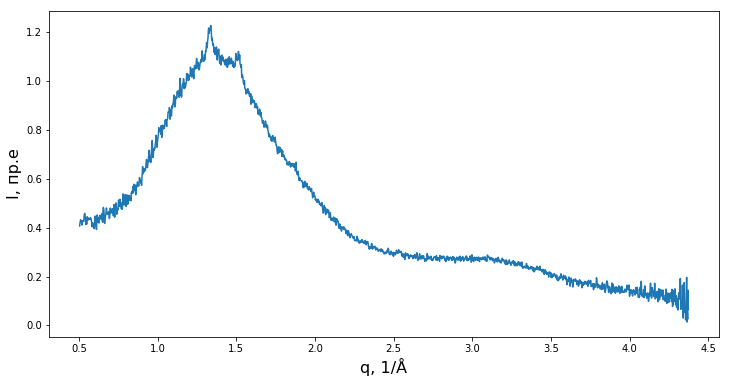

In [24]:
fig = plt.figure(figsize=(12,6))
plt.plot(q_set[230:],profile[230:] )
plt.ylabel("I, пр.е", fontsize = 16)
plt.xlabel("q, 1/\u212B", fontsize = 16)
plt.savefig('profile.pdf')

In [21]:
scan = all_scans[1]
mask = scan>0
np.save('mask72',mask)

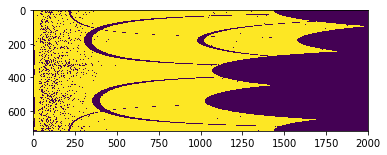

In [22]:
plt.imshow(mask)

In [14]:
counts = np.zeros(all_scans.shape[2], dtype=np.float32)
current_scan = mask
for chi in range(all_scans.shape[1]):
    if chi not in range(300,330):
            for q in range(all_scans.shape[2]):
                if current_scan[chi,q]:
                    counts[q]+=1
                        

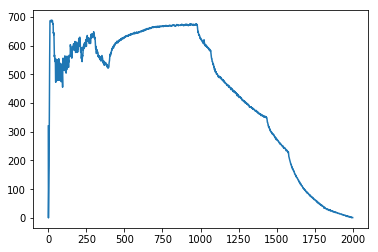

In [15]:
plt.plot(counts)

In [19]:
np.save('counts72', counts)

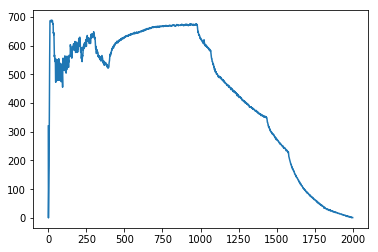

In [24]:
f.close()

In [29]:
f = h5py.File("mytestfile.hdf5", "r")
data = f['data']


In [46]:
profile = data[14640]

Text(0.5, 0, 'q, 1/Å')

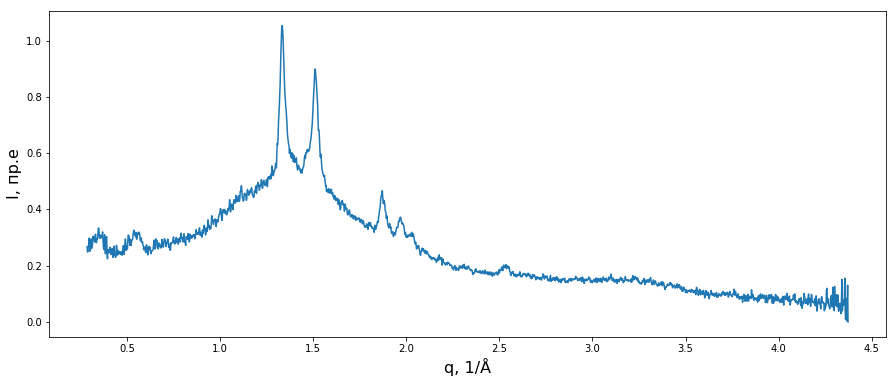

In [60]:
fig = plt.figure(figsize=(15,6))
plt.plot(q_set[130:],profile[130:])
plt.ylabel("I, пр.е", fontsize = 16)
plt.xlabel("q, 1/\u212B", fontsize = 16)
#plt.savefig('profile.pdf')